# Try using Auto_ARIMA and SARIMAX to predict Stock Price

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
#warnings.filterwarnings('ignore')

#print("Python version:", sys.version)

In [2]:
import platform
print("Python version: ",platform.python_version())

Python version:  3.10.13


In [3]:
#!pip install statsmodels --quiet
import statsmodels
print("statsmodels version: ",statsmodels.__version__)

statsmodels version:  0.14.1


In [4]:
#!pip install yfinance  # Yahoo! Finance's API
import yfinance as yf

In [5]:
#Data Manipulation and Treatment
import numpy as np
import pandas as pd
from datetime import date
import itertools

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

#Statistics & Modeling

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
#!pip install pmdarima --quiet
import pmdarima as pm

#import tensorflow as tf
#from sklearn.preprocessing import MinMaxScaler

In [6]:
from statsmodels.tools.sm_exceptions import ValueWarning , ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [7]:
from timeit import default_timer as timer
from datetime import timedelta

In [8]:
print(f"Using pmdarima {pm.__version__}")
#print(f"Using TensorFlow {tf.__version__}")

Using pmdarima 2.0.4


### Load Data:

In [9]:
# Date must be in the fromat ("%Y-%m-%d") That is, year-month-day
start_date = '2000-1-1' #1 Jan 2000
end_date = '2023-12-31'             # date.today()    #2 current date
# "start_date" must be an older date than the "end_date"

ticker = "AMZN"

stock = yf.download(tickers = ticker,
                  start = start_date,
                  end = end_date)

[*********************100%%**********************]  1 of 1 completed


### Explore Data:

In [10]:
stock.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [11]:
stock.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000
2023-12-29,153.100006,153.889999,151.029999,151.940002,151.940002,39789000


In [12]:
#Checks shape
print(stock.shape)

(6037, 6)


In [13]:
#Checks dataset information
print(stock.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6037 entries, 2000-01-03 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       6037 non-null   float64
 1   High       6037 non-null   float64
 2   Low        6037 non-null   float64
 3   Close      6037 non-null   float64
 4   Adj Close  6037 non-null   float64
 5   Volume     6037 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 330.1 KB
None


In [14]:
stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6037.000000,6037.000000,6037.000000,6037.000000,6037.000000,6.037000e+03
mean,37.918211,38.368754,37.429891,37.909060,37.909060,1.217359e+08
std,51.570914,52.176971,50.906212,51.542803,51.542803,9.828832e+07
min,0.295500,0.305000,0.275500,0.298500,0.298500,1.762600e+07
25%,2.268000,2.303500,2.229500,2.269500,2.269500,6.572600e+07
50%,10.266500,10.400000,10.105000,10.272000,10.272000,9.936200e+07
75%,59.740002,60.266998,59.415001,59.680000,59.680000,1.461800e+08
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.086584e+09


In [15]:
stock.isnull().sum(axis=0) # check any NA

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

Text(0.5, 1.0, 'The Stock Close Price of AMZN')

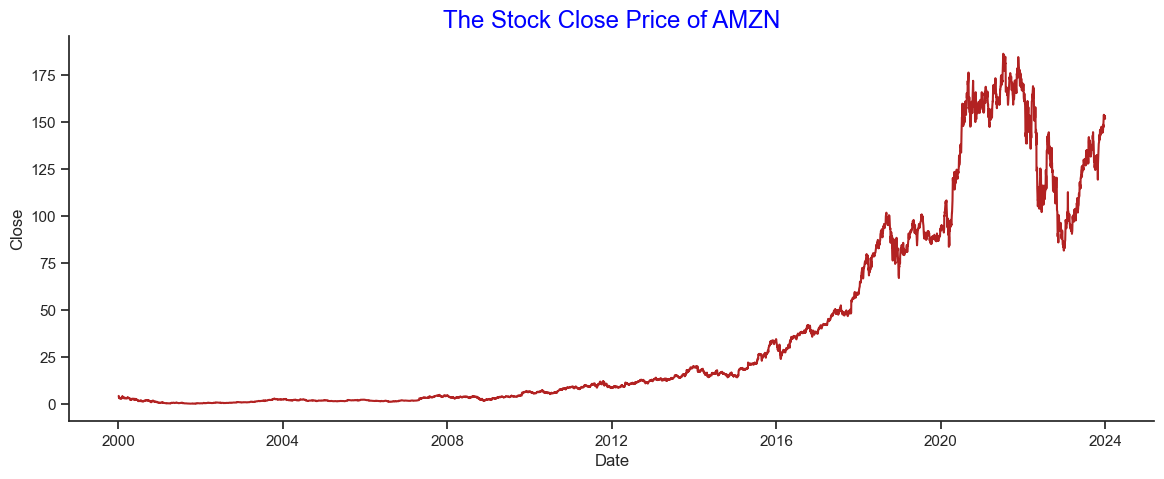

In [16]:
#https://levelup.gitconnected.com/how-to-plot-stock-prices-using-python-87ba684d126c

plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=stock,x="Date",y='Close',color='firebrick')
sns.despine()
plt.title("The Stock Close Price of " + ticker,size='x-large',color='blue')

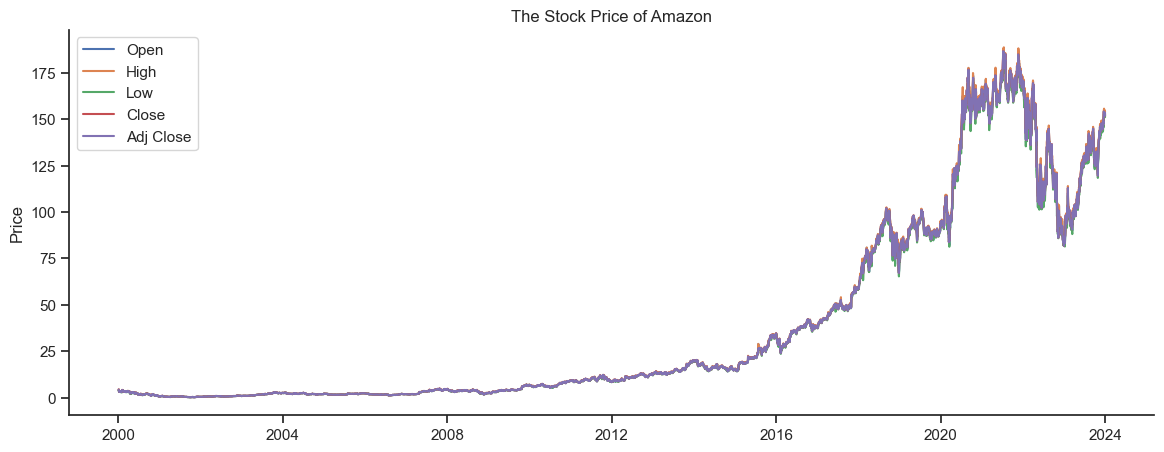

In [17]:
# Plot  time series of wind and solar power
fig, ax = plt.subplots(figsize=(14, 5))
for nm in ['Open','High','Low','Close','Adj Close']:
    ax.plot(stock[nm], label=nm)

ax.legend()
ax.set_ylabel('Price')
ax.set_title('The Stock Price of Amazon')
sns.despine()
plt.show()

In [18]:
stock2 = stock.copy()

In [19]:
stock2.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,4.075000,4.478125,3.952344,4.468750,4.468750,322352000
2000-01-04,4.268750,4.575000,4.087500,4.096875,4.096875,349748000
2000-01-05,3.525000,3.756250,3.400000,3.487500,3.487500,769148000
2000-01-06,3.565625,3.634375,3.200000,3.278125,3.278125,375040000
2000-01-07,3.350000,3.525000,3.309375,3.478125,3.478125,210108000


In [20]:
# add few more attributes
# Add columns with year, month, and weekday name
stock2['Year'] = stock.index.year
stock2['Month'] = stock.index.month
stock2['Quarter'] = stock.index.quarter
stock2['Weekday Name'] = stock.index.day_name()

# Display a random sampling of 5 rows
stock2.sample(5, random_state=0)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Quarter,Weekday Name
Date,,,,,,,,,,
2006-08-07,1.359500,1.364500,1.329500,1.339000,1.339000,109528000,2006,8,3,Monday
2021-03-04,150.600006,152.906494,147.271500,148.878494,148.878494,109632000,2021,3,1,Thursday
2003-08-19,2.172500,2.209500,2.146000,2.178500,2.178500,209786000,2003,8,3,Tuesday
2017-06-23,50.126999,50.230999,49.901001,50.187000,50.187000,57582000,2017,6,2,Friday
2000-10-25,1.700000,1.825000,1.587500,1.593750,1.593750,571458000,2000,10,4,Wednesday


In [21]:
#print(stock2.groupby('Year').size())

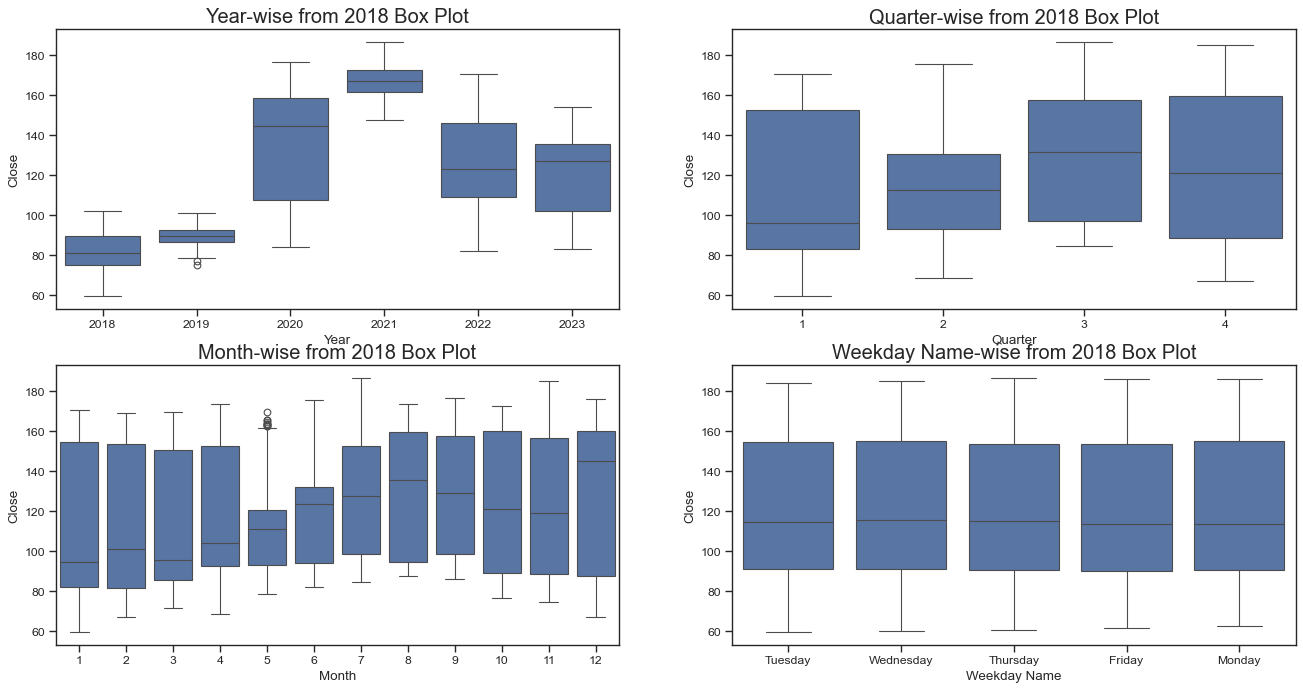

In [22]:
# plot from year 2018

fig, axes = plt.subplots(2, 2, figsize=(20,10), dpi= 80)
sns.boxplot(x='Year', y='Close', data=stock2[stock2['Year']>=2018], ax=axes[0][0])
sns.boxplot(x='Quarter', y='Close', data=stock2[stock2['Year']>=2018], ax=axes[0][1])
sns.boxplot(x='Month', y='Close', data=stock2[stock2['Year']>=2018], ax=axes[1][0])
sns.boxplot(x='Weekday Name', y='Close', data=stock2[stock2['Year']>=2018], ax=axes[1][1])

# Set Title
axes[0][0].set_title('Year-wise from 2018 Box Plot', fontsize=18); 
axes[0][1].set_title('Quarter-wise from 2018 Box Plot', fontsize=18)
axes[1][0].set_title('Month-wise from 2018 Box Plot', fontsize=18); 
axes[1][1].set_title('Weekday Name-wise from 2018 Box Plot', fontsize=18)
plt.show()

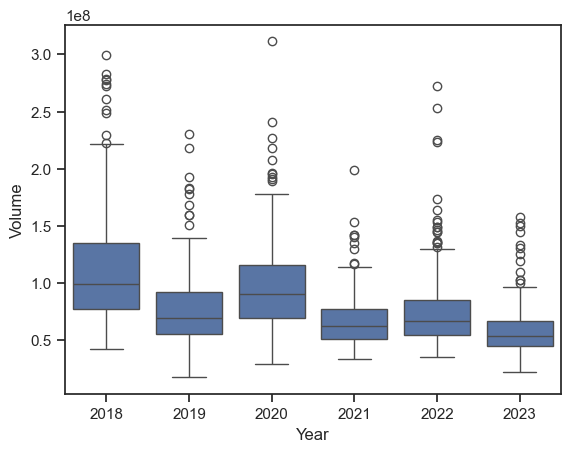

In [23]:
sns.boxplot(data=stock2[stock2['Year']>=2018], x='Year', y='Volume');

Text(0.5, 1.0, 'Year 2023')

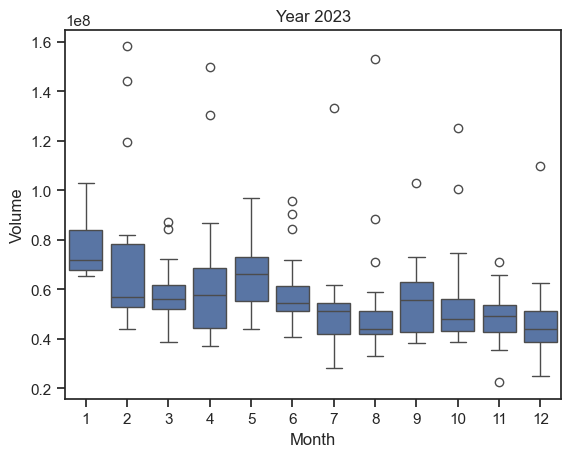

In [24]:
# Let’s plot the time series in a single year

sns.boxplot(data=stock2[stock2['Year']==2023], x='Month', y='Volume');
plt.title('Year 2023')

### Polynomial Regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
stock3 = stock.copy()
stock3.reset_index(inplace=True)

# Independent variable (time) 
X = np.array(stock3['Date'].index).reshape(-1, 1)  # transforms our numpy array x from a 1D array to a 2D array
y = stock3['Close'].values  # Dependent variable (value)

In [26]:
#Creating a polynomial regression model

degree = 2  # Set the degree of the polynomial
poly_features = PolynomialFeatures(degree=degree, include_bias=False) #include_bias=False should be set to False, 
                                                        # because we’ll use PolynomialFeatures together with LinearRegression()

# fit() declare what feature we want to transform
# transform() performs the actual transformation
X_poly = poly_features.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)

LinearRegression()

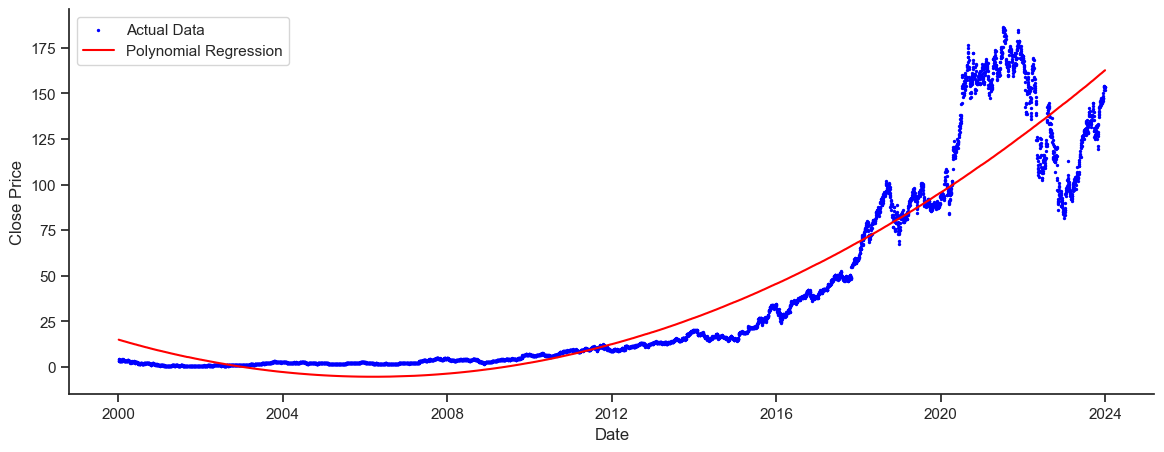

In [27]:
# Visualize real data with polynomial regression
plt.figure(figsize=(14,5))
plt.scatter(stock3['Date'], y, color='blue', label='Actual Data',s=2)
plt.plot(stock3['Date'], model.predict(X_poly), color='red', label='Polynomial Regression')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
sns.despine()
plt.show()

### Holt-Winters Exponential Smoothing

In [28]:
# holt winters 
# single exponential smoothing
# SimpleExpSmoothing   
# double and triple exponential smoothing
# ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

#### Triple HWES
#### https://medium.com/analytics-vidhya/python-code-on-holt-winters-forecasting-3843808a9873

In [29]:
stock4=stock.copy()

In [30]:
#stock4 = stock4.asfreq('B')

In [31]:
stock4.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,153.770004,154.350006,152.710007,153.419998,153.419998,29480100
2023-12-26,153.559998,153.979996,153.029999,153.410004,153.410004,25067200
2023-12-27,153.559998,154.779999,153.119995,153.339996,153.339996,31434700
2023-12-28,153.720001,154.080002,152.949997,153.380005,153.380005,27057000
2023-12-29,153.100006,153.889999,151.029999,151.940002,151.940002,39789000


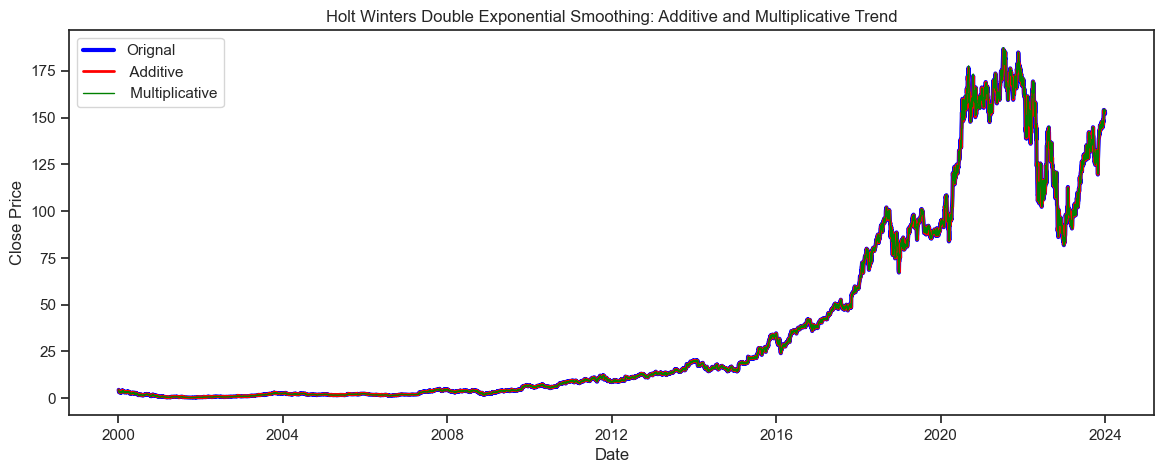

In [32]:
plt.figure(figsize=(14,5))
stock4['Close_ADD'] = ExponentialSmoothing(stock4['Close'],
                                           trend='add',
                                           seasonal='add',
                                           seasonal_periods=7).fit().fittedvalues
stock4['Close_MUL'] = ExponentialSmoothing(stock4['Close'],
                                                    trend='mul',
                                                    seasonal='mul',
                                                    seasonal_periods=7).fit().fittedvalues

plt.plot(stock4['Close'], color='blue',  label='Orignal',linewidth=3)
plt.plot(stock4['Close_ADD'], color='red', label=' Additive',linewidth=2)
plt.plot(stock4['Close_MUL'], color='green', label=' Multiplicative',linewidth=1)
plt.title('Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show();

### Check for Stationarity:

In [33]:
result = adfuller(stock2['Close'],regression ='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: -2.580952
p-value: 0.522767
Critical Values:
	1%: -4.373
	5%: -3.833
	10%: -3.554
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


### Seasonal Decomposition:

In [34]:
# 5 trading days in a week
# Multiplicative Decomposition 
result_mul_p5 = seasonal_decompose(stock2['Close'].dropna(), model='multiplicative', period=5) 
trend_mul_p5 = result_mul_p5.trend
seasonal_mul_p5 = result_mul_p5.seasonal
residual_mul_p5 = result_mul_p5.resid
# Additive Decomposition
result_add_p5 = seasonal_decompose(stock2['Close'].dropna(), model='additive', period=5)
trend_add_p5 = result_add_p5.trend
seasonal_add_p5 = result_add_p5.seasonal
residual_add_p5 = result_add_p5.resid

# 20 trading days per month
# Multiplicative Decomposition 
result_mul_p20 = seasonal_decompose(stock2['Close'].dropna(), model='multiplicative', period=20) 
trend_mul_p20 = result_mul_p20.trend
seasonal_mul_p20 = result_mul_p20.seasonal
residual_mul_p20 = result_mul_p20.resid
# Additive Decomposition
result_add_p20 = seasonal_decompose(stock2['Close'].dropna(), model='additive', period=20)
trend_add_p20 = result_add_p20.trend
seasonal_add_p20 = result_add_p20.seasonal
residual_add_p20 = result_add_p20.resid

# 253 trading days per year
# Multiplicative Decomposition 
result_mul_p253 = seasonal_decompose(stock2['Close'].dropna(), model='multiplicative', period=253) 
trend_mul_p253 = result_mul_p253.trend
seasonal_mul_p253 = result_mul_p253.seasonal
residual_mul_p253 = result_mul_p253.resid
# Additive Decomposition
result_add_p253 = seasonal_decompose(stock2['Close'].dropna(), model='additive', period=253)
trend_add_p253 = result_add_p253.trend
seasonal_add_p253 = result_add_p253.seasonal
residual_add_p253 = result_add_p253.resid

In [35]:
# HWES 5 trading days in a week
# Multiplicative Decomposition 
HWES_result_mul_p5 = seasonal_decompose(stock4['Close_MUL'].dropna(), model='multiplicative', period=5) 
HWES_trend_mul_p5 = HWES_result_mul_p5.trend
HWES_seasonal_mul_p5 = HWES_result_mul_p5.seasonal
HWES_residual_mul_p5 = HWES_result_mul_p5.resid
# Additive Decomposition
HWES_result_add_p5 = seasonal_decompose(stock4['Close_ADD'].dropna(), model='additive', period=5)
HWES_trend_add_p5 = HWES_result_add_p5.trend
HWES_seasonal_add_p5 = HWES_result_add_p5.seasonal
HWES_residual_add_p5 = HWES_result_add_p5.resid

#### Select an appropriate value for the frequency/period parameter. 
#### Reference from https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453

#### Stationarity for different period

In [36]:
print("multiplicative - period 5")
print("--------------------------------")
result = adfuller(residual_mul_p5.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')
print()
    
print("multiplicative - period 20")
print("--------------------------------")
result = adfuller(residual_mul_p20.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')
print()

print("multiplicative - period 253")
print("--------------------------------")
result = adfuller(residual_mul_p253.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')
print()

print("additive - period 5")
print("--------------------------------")
result = adfuller(residual_add_p5.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')
print()    
    
print("additive - period 20")
print("--------------------------------")
result = adfuller(residual_add_p20.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')    
print()    
    
print("additive - period 253")
print("--------------------------------")
result = adfuller(residual_add_p253.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

multiplicative - period 5
--------------------------------
ADF Statistic: -20.326190
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

multiplicative - period 20
--------------------------------
ADF Statistic: -20.951497
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

multiplicative - period 253
--------------------------------
ADF Statistic: -9.083062
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

additive - period 5
--------------------------------
ADF Statistic: -23.895666
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

additive - period 20
---

#### Stationarity for HWES

In [37]:
print("HWES_multiplicative - period 5")
print("--------------------------------")
result = adfuller(HWES_residual_mul_p5.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')
print()

print("HWES_additive - period 5")
print("--------------------------------")
result = adfuller(HWES_residual_add_p5.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] <= 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

HWES_multiplicative - period 5
--------------------------------
ADF Statistic: -19.494688
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

HWES_additive - period 5
--------------------------------
ADF Statistic: -23.879977
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


#### ADF Statistic of "Additive of period 5" gives more negative than the critical values

#### *If the test statistic is more negative than the critical value, you can reject the null hypothesis and conclude that the time series is stationary. If the test statistic is less negative than the critical value, you cannot reject the null hypothesis and conclude that the time series has a unit root.  *https://www.linkedin.com/advice/0/how-do-you-interpret-results-augmented-dickey-fuller

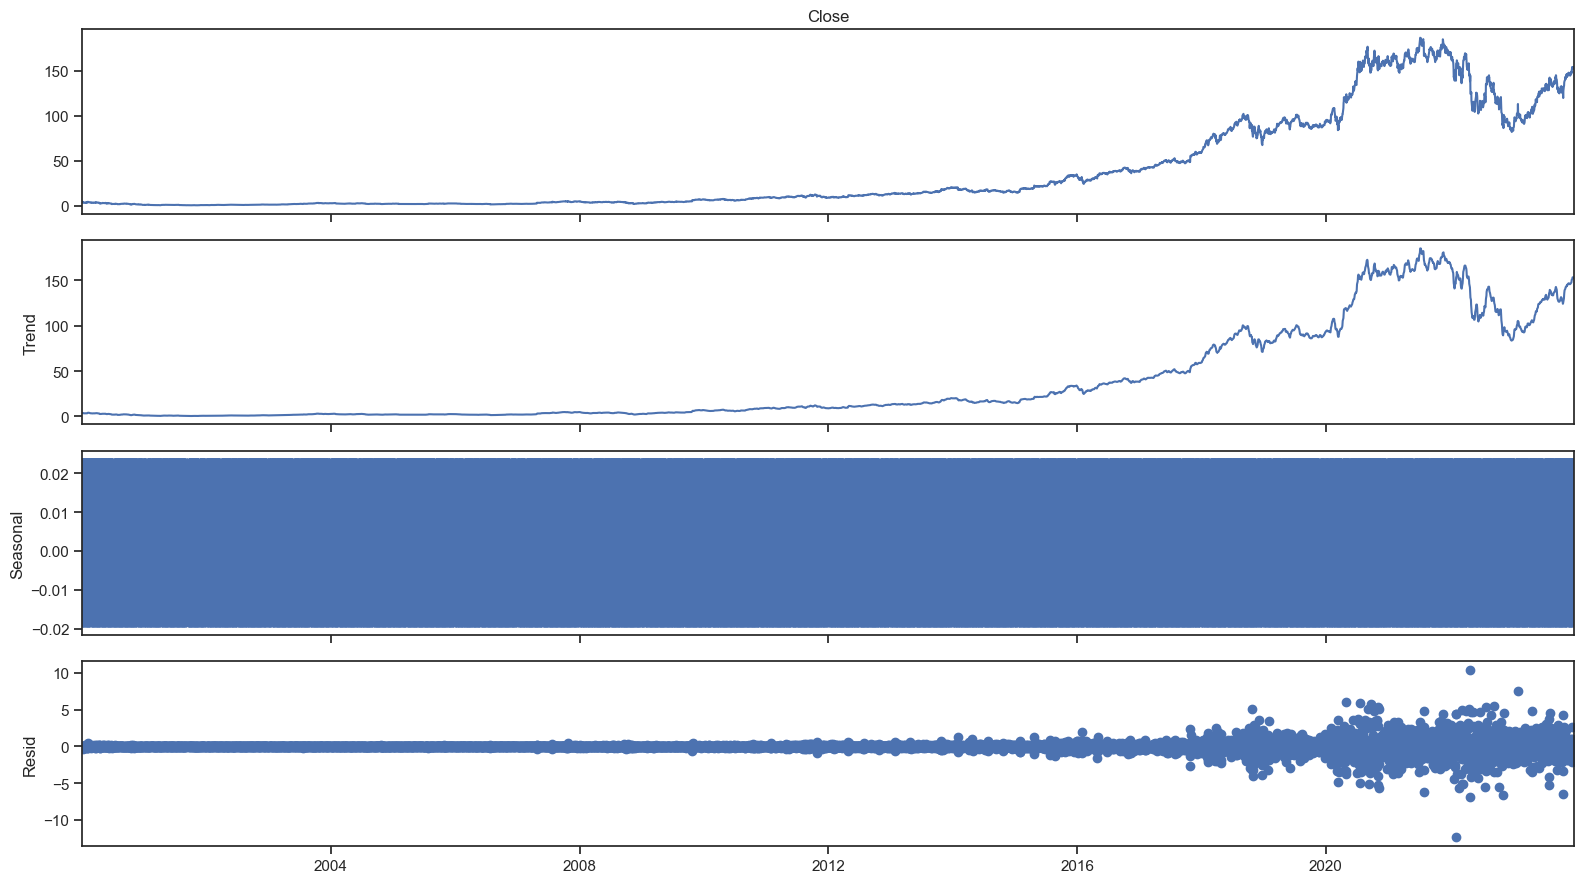

In [38]:
# Plot "Additive of period 5" Decomposition
fig = result_add_p5.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

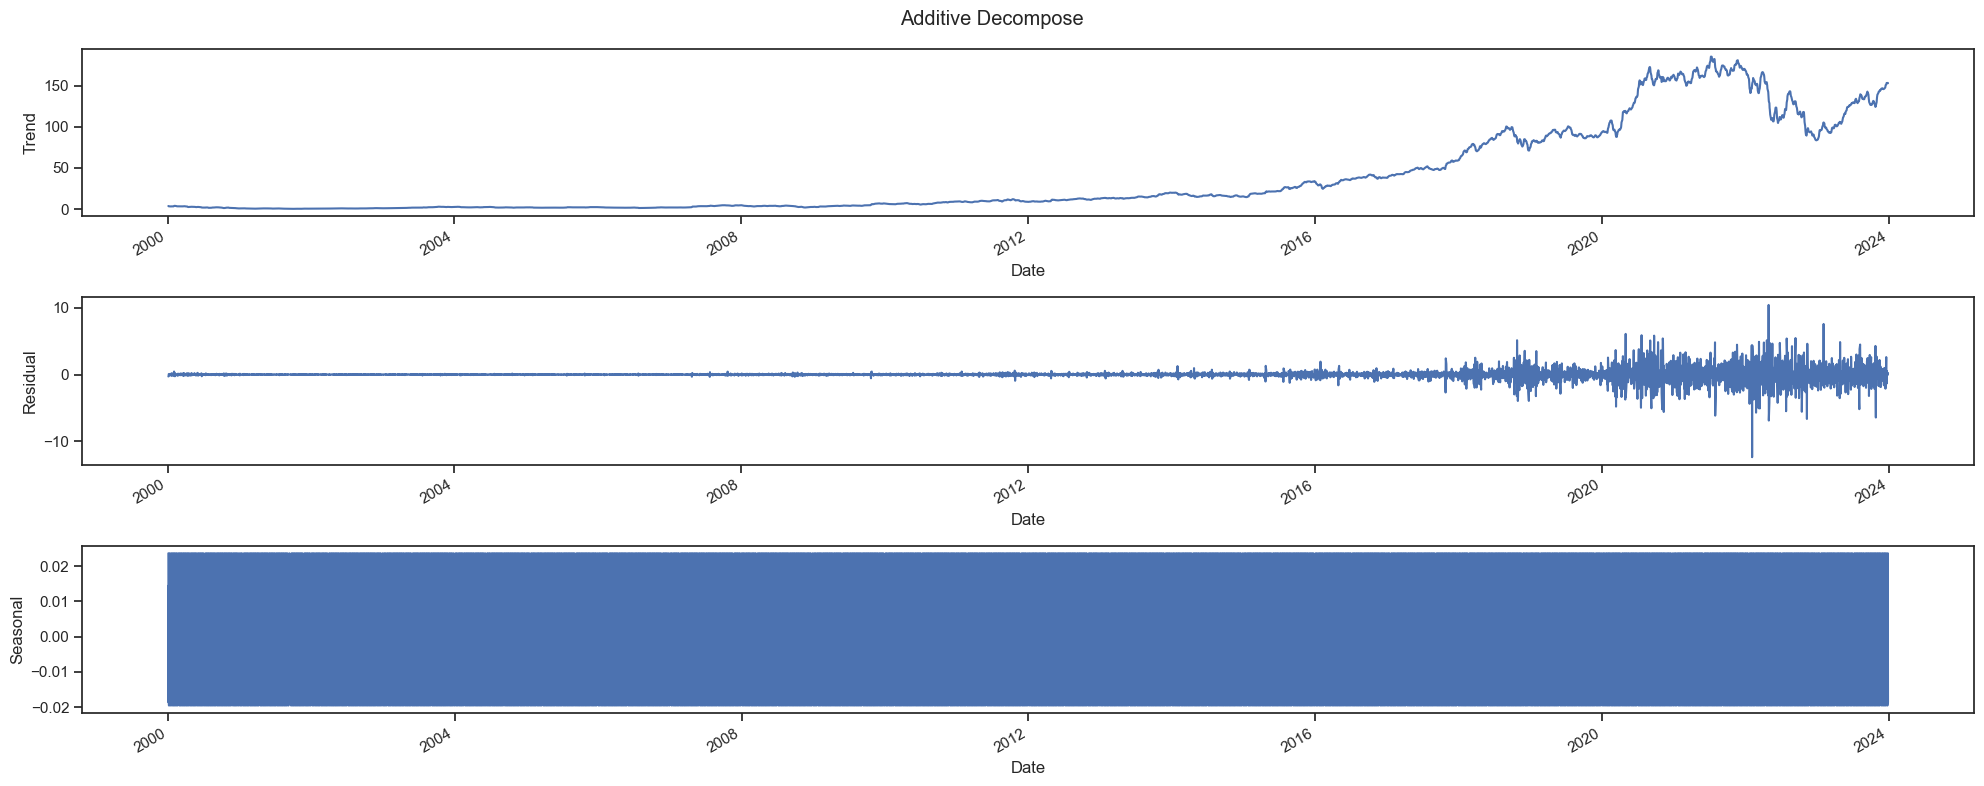

In [39]:
# Alternative Plot 

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,8))
result_add_p5.trend.plot(ax=ax1)
ax1.set_ylabel("Trend")
result_add_p5.resid.plot(ax=ax2)
ax2.set_ylabel("Residual")
result_add_p5.seasonal.plot(ax=ax3)
ax3.set_ylabel("Seasonal")
plt.suptitle('Additive Decompose')
fig.tight_layout()
plt.show()

### Making a Time Series Stationary
#### Method 1: Log Transformation

In [40]:
stock2['log_Close'] = np.log(stock2['Close'])

In [41]:
result = adfuller(stock2['log_Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] < 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: 0.084691
p-value: 0.965000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


#### Method 2: Rolling Mean

In [42]:
# by 5 days
#rolling_mean = stock2['Close'].rolling(window=5).mean()
#stock2['5D_rolling_Close'] = stock2['Close'] - rolling_mean
stock2['5D_rolling_Close'] = stock2['Close'].rolling(window=5).mean()
# by 252 days (~1 year: business days)
# rolling_mean = stock2['Close'].rolling(window=252).mean()
# stock2['252D_rolling_Close'] = stock2['Close'] - rolling_mean

In [43]:
result = adfuller(stock2['5D_rolling_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] < 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: 0.439602
p-value: 0.982917
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


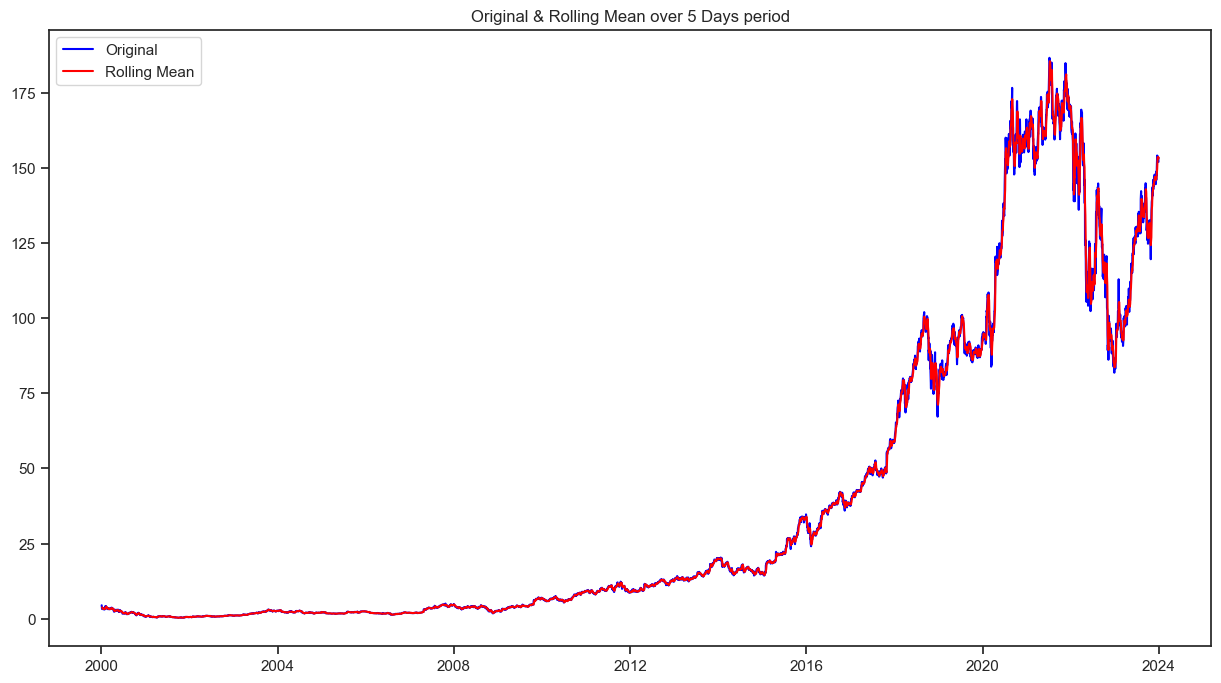

In [44]:
#Plot rolling statistics:
fig = plt.figure(figsize=(15, 8))
plt.plot(stock2['Close'], color='blue',label='Original')
plt.plot(stock2['5D_rolling_Close'], color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Original & Rolling Mean over 5 Days period')
plt.show()

#### Method  3: differencing

In [45]:
#stock2['diff5_Close'] = stock2['Close'].rolling(window=5).apply(lambda x: x[0]-x[-1], raw=True)
stock2['diff5_Close'] = stock2['Close'].diff(periods = 5)

In [46]:
result = adfuller(stock2['diff5_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] < 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: -14.082652
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


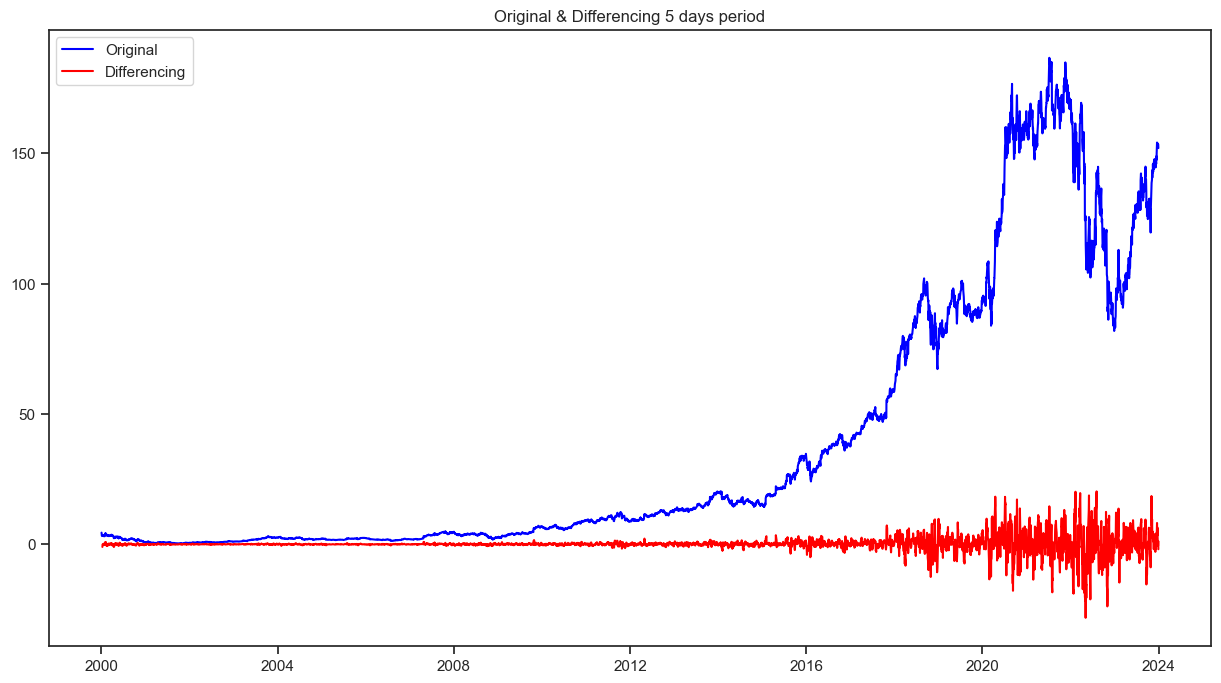

In [47]:
fig = plt.figure(figsize=(15, 8))
plt.plot(stock2['Close'], color='blue',label='Original')
plt.plot(stock2['diff5_Close'], color='red', label='Differencing')
plt.legend(loc='best')
plt.title('Original & Differencing 5 days period')
plt.show()

#### Method  4: weighted rolling mean

In [48]:
# Exponentially weighted mean
stock2['wgt_rolling_Close'] = stock2['Close'].ewm(halflife='5 days', times=stock2.index).mean() 

In [49]:
result = adfuller(stock2['wgt_rolling_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] < 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: 0.393836
p-value: 0.981263
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


#### Method 5:  Second order differencing

In [50]:
stock2['diff_2nd_Close'] = stock2['Close'].diff().diff()

In [51]:
result = adfuller(stock2['diff_2nd_Close'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
if result[1]  > 0.05 :
    print('Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.')
elif result[1] < 0.05 :
    print('Reject the null hypothesis (H0), the data does not have a unit root and is stationary.')

ADF Statistic: -23.737756
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


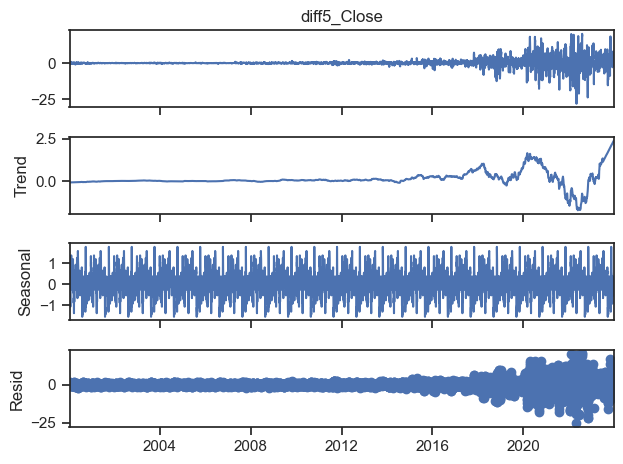

In [52]:
decompose_result = seasonal_decompose(stock2['diff5_Close'].dropna(),period=253, model='additive',extrapolate_trend='freq')

decompose_result.plot();

####  Differencing 5 days able to remove the trend from time-series data. But still have Seasonality. The differencing also removed the upward trend of the time series although the variance is still time dependent.

### Autocorrelation and Partial Autocorrelation Analysis:

####   Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

#### https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788

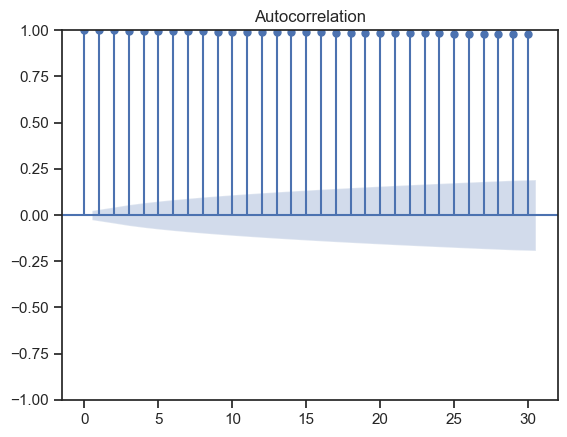

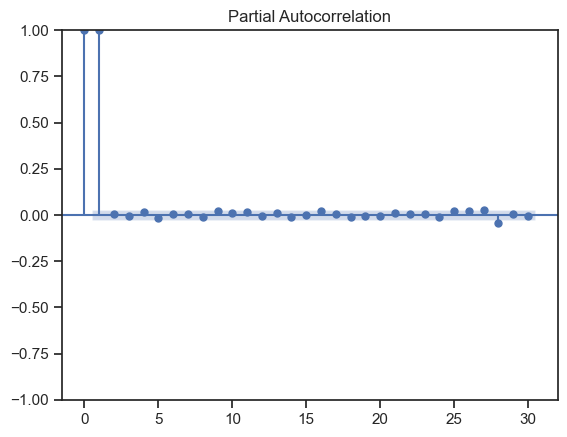

In [53]:
plot_acf(stock2['Close'].dropna(),lags = 30);
plot_pacf(stock2['Close'].dropna(),lags = 30);

#### The orignal series “ACF” chart shows non-stationary data, characterized by the slow linear decay in the spikes

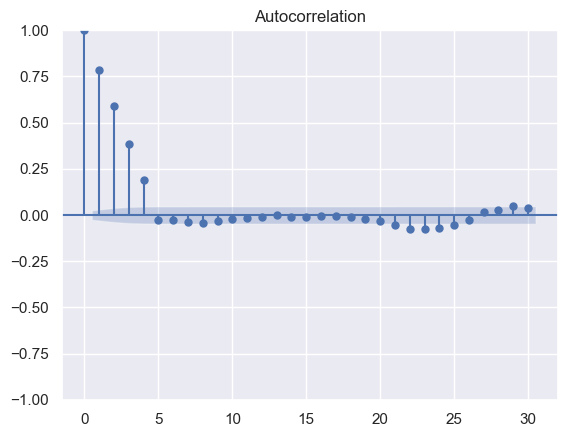

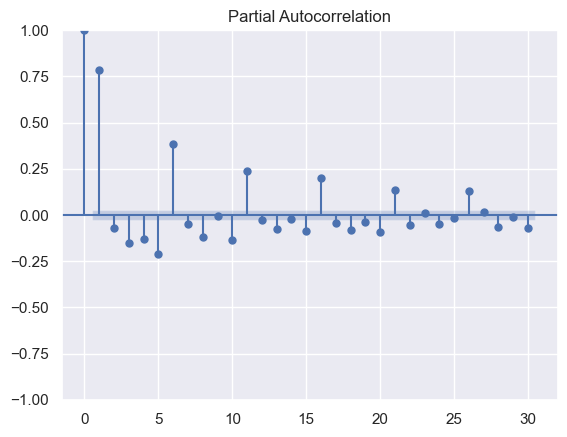

In [54]:
sns.set_style("darkgrid")
plot_acf(stock2['diff5_Close'].dropna(), lags=30)
plot_pacf(stock2['diff5_Close'].dropna(), lags=30)
plt.show()

#### Adding a 1st order difference gives, there are several spikes above the blue region, meaning there are correlations at lags 1, 2, 3 and 4 on ACF plot

#### We can notice from the above ACF chart that after 4 lags, the line gets inside confidence interval (light blue area). This can be due to seasonality of 4 days in our data. 

#### Tail off is observed at ACF plot. Thus, it’s a AR model. From PACF, cut off happens at lag 8 and declining graually with every 5th lag. So it should be Seasonal-AR(1) model.

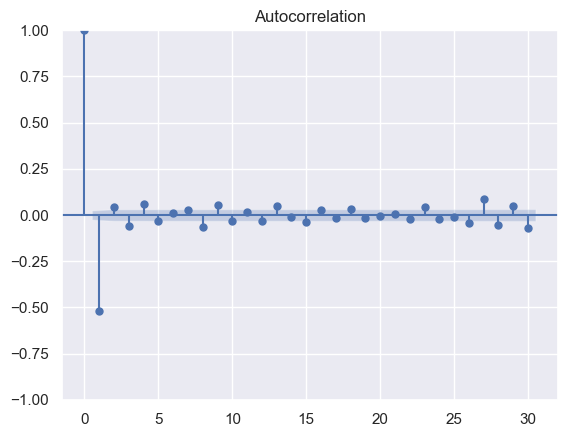

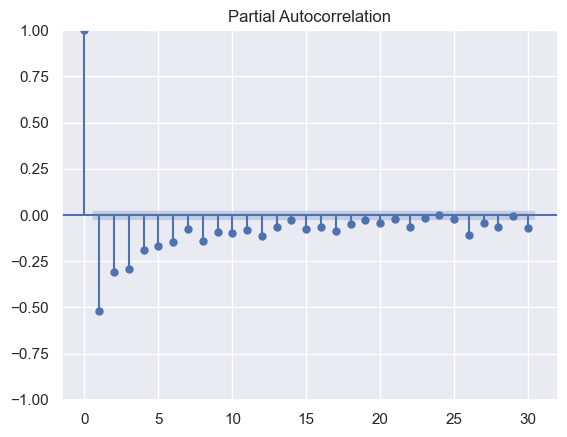

In [55]:
sns.set_style("darkgrid")
plot_acf(stock2['diff_2nd_Close'].dropna(), lags=30)
plot_pacf(stock2['diff_2nd_Close'].dropna(), lags=30)
plt.show()

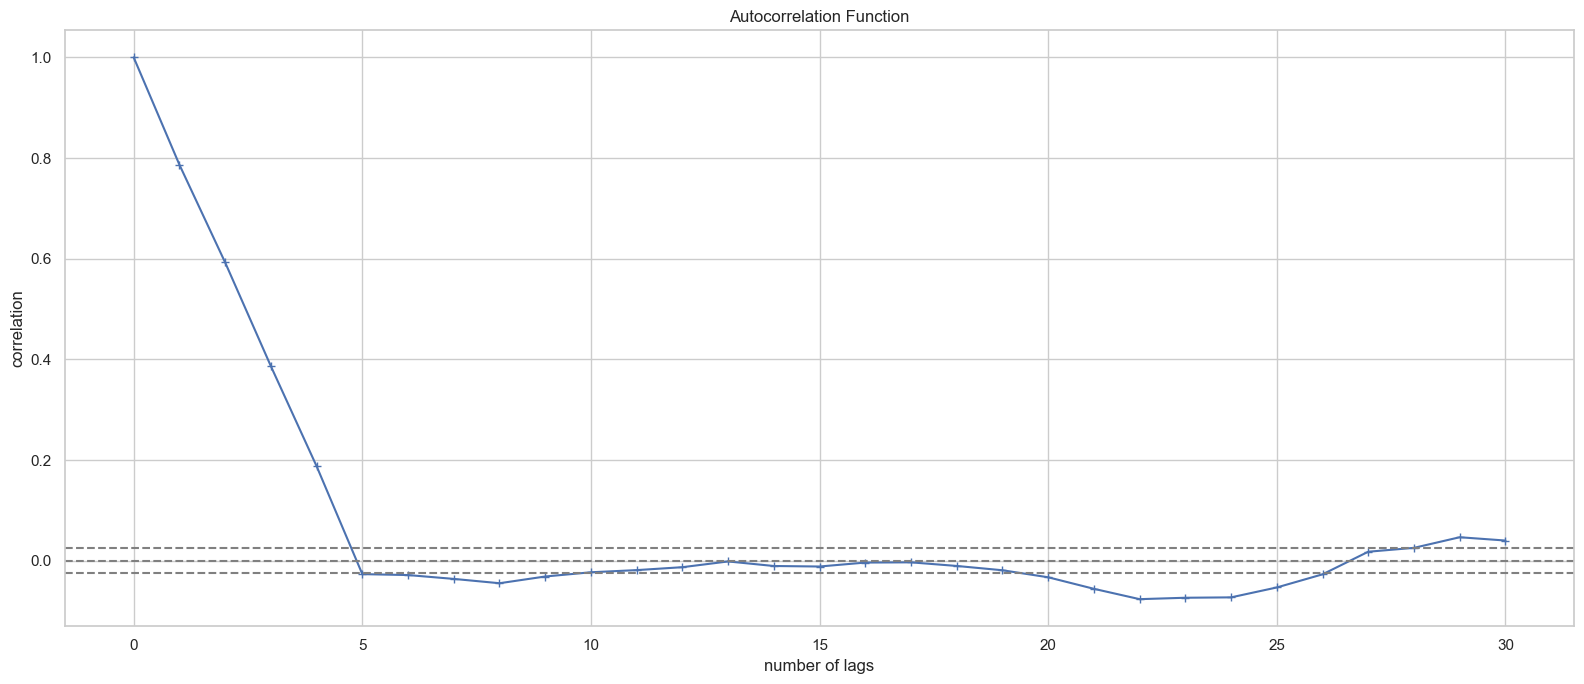

In [56]:
# https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
sns.set(style="whitegrid", color_codes=True)

y= stock2['diff5_Close'].dropna()

#calling auto correlation function
lag_acf = acf(y, nlags=30)

#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_acf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.xlabel('number of lags')
plt.ylabel('correlation')
plt.tight_layout()

#### In the above correlation plot dotted lines represent the confidence band, with center dotted line represents mean and upper and lower dotted line represent boundries based on 95% confidence interval. Cuts off after the lag 4 - > MA(4) model

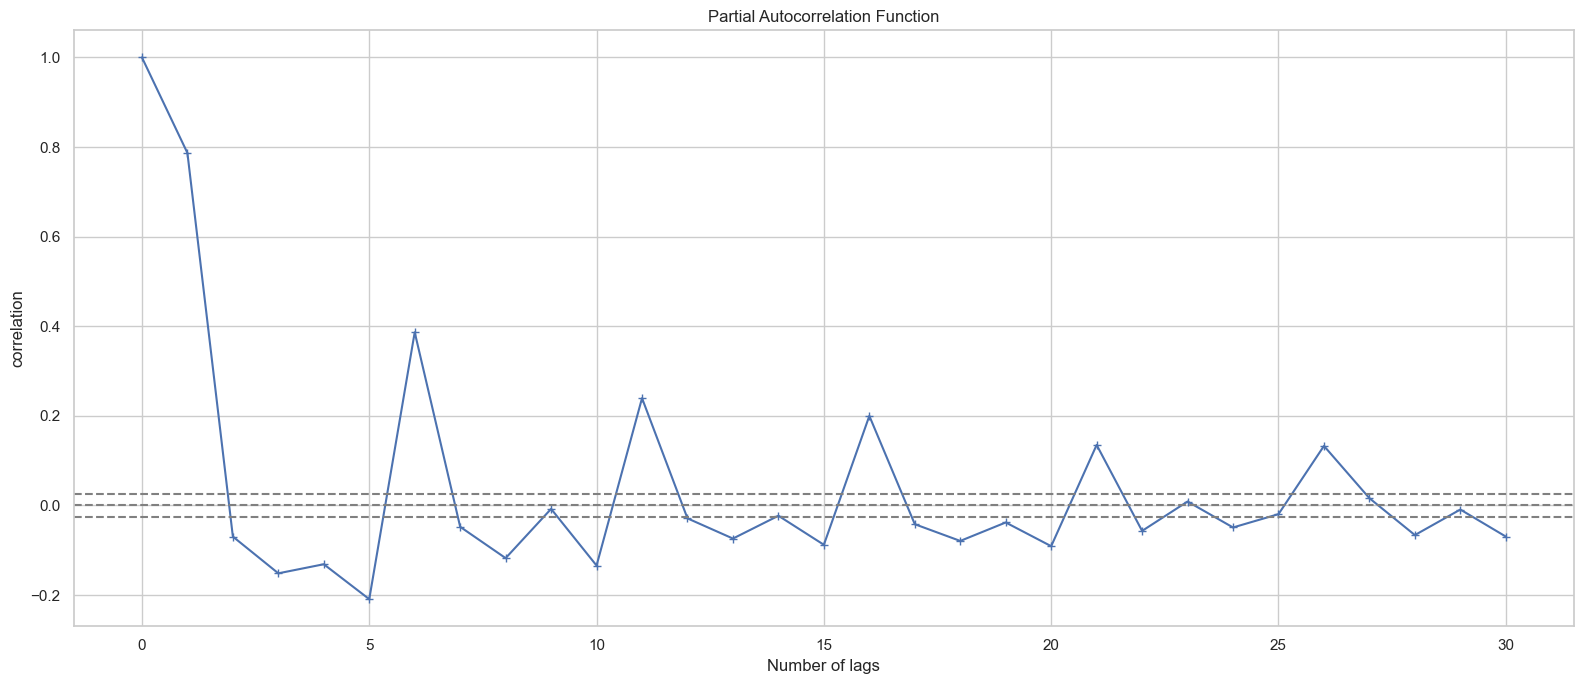

In [57]:
#calling partial correlation function from stattool
y=stock2['diff5_Close'].dropna()
lag_pacf = pacf(y, nlags=30, method='ols')

#Plot PACF:

plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

#### In the above plot we can see that lags upto 1 have good correlation before the plot first cuts the upper confidence interval. This is our p value i.e the order of our AR process. We can model given AR process using linear combination of first 1 lags

#### In the PACF plot the cutoff is at lag 1 and the appropriate model would be an AR model of order AR(p) = 1

### Remove Seasonality 
#### Method1:  Differencing Over Time-Series with Rolling Mean taken over 50 Days

In [58]:
#  we are shifting time-series by 1 period and differencing it from de-trended time-series.
stock2['50D_rolling_Close'] = stock2['Close'].rolling(window=50).mean()
stock2['50D_rolling_diff_Close'] = stock2['50D_rolling_Close']  - stock2['50D_rolling_Close'].shift()

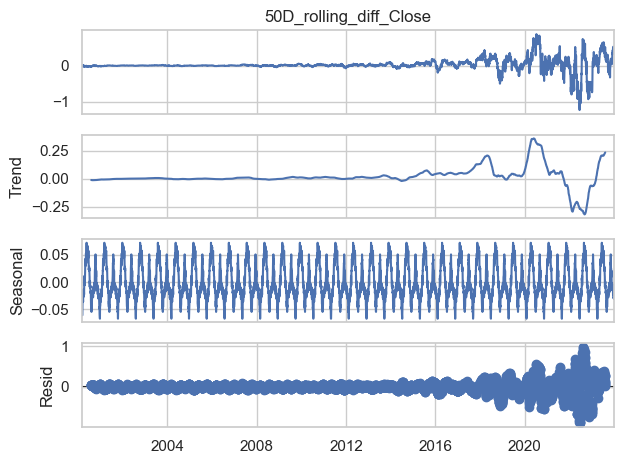

In [59]:
decompose_result = seasonal_decompose(stock2['50D_rolling_diff_Close'].dropna(),period=200)

decompose_result.plot();

#### Method 2: Differencing Over Power Transformed & Mean Rolled

In [60]:
stock2['pow_Close'] =stock2["Close"].apply(lambda x : x ** 0.5)
stock2['pow_rolled_Close'] = stock2['pow_Close'] - stock2['50D_rolling_Close']
stock2['pow_rolled_diff_Close'] = stock2['pow_rolled_Close'] - stock2['pow_rolled_Close'].shift()

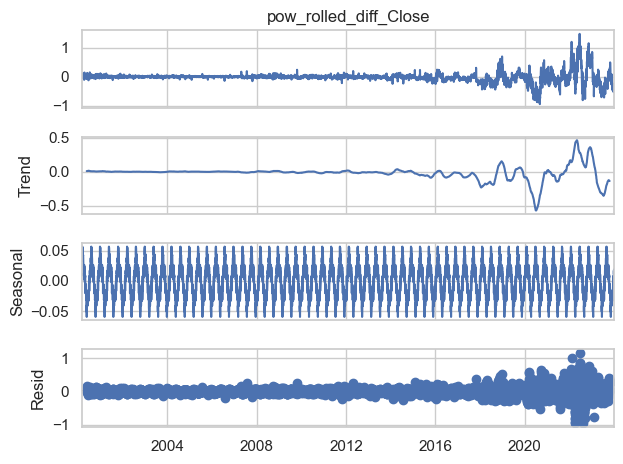

In [61]:
decompose_result = seasonal_decompose(stock2['pow_rolled_diff_Close'].dropna(),period=100)

decompose_result.plot();

#### Method 3: Differencing Over Log Transformed & Mean Rolled

In [62]:
stock2['log_rolled_Close'] = stock2['log_Close'] - stock2['50D_rolling_Close']
stock2['log_rolled_diff_Close'] = stock2['log_rolled_Close'] - stock2['log_rolled_Close'].shift()

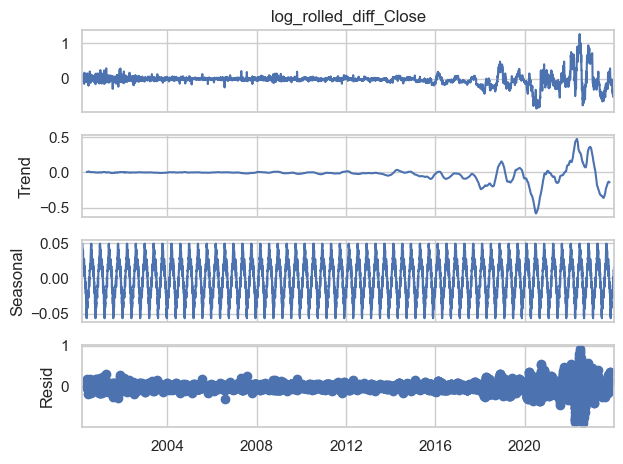

In [63]:
decompose_result = seasonal_decompose(stock2['log_rolled_diff_Close'].dropna(),period=100)

decompose_result.plot();

#### Unable to remove seasonality

In [64]:
#del stock2['pow_rolled_Close']
#stock2.info()
#stock2.tail()

## Build Model:

In [65]:
#splitting the data to train and test sets based on Ntest value
#last 253 days (1 year business day)
Ntest = 253

In [66]:
train_df = stock2.iloc[:-Ntest]
test_df = stock2.iloc[-Ntest:]

In [67]:
train_df.index

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-10', '2000-01-11', '2000-01-12',
               '2000-01-13', '2000-01-14',
               ...
               '2022-12-13', '2022-12-14', '2022-12-15', '2022-12-16',
               '2022-12-19', '2022-12-20', '2022-12-21', '2022-12-22',
               '2022-12-23', '2022-12-27'],
              dtype='datetime64[ns]', name='Date', length=5784, freq=None)

In [68]:
train_df.asfreq('D').index  # set index frequency to daliy

DatetimeIndex(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06',
               '2000-01-07', '2000-01-08', '2000-01-09', '2000-01-10',
               '2000-01-11', '2000-01-12',
               ...
               '2022-12-18', '2022-12-19', '2022-12-20', '2022-12-21',
               '2022-12-22', '2022-12-23', '2022-12-24', '2022-12-25',
               '2022-12-26', '2022-12-27'],
              dtype='datetime64[ns]', name='Date', length=8395, freq='D')

#### HWES forecast

In [69]:
# https://timeseriesreasoning.com/contents/holt-winters-exponential-smoothing/
HWES_model = ExponentialSmoothing(train_df['Close'],
                        trend='add',
                        seasonal='add',
                        seasonal_periods=7)
HWES_model_fitted = HWES_model.fit()

In [70]:
print(HWES_model_fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 5784
Model:             ExponentialSmoothing   SSE                           9719.299
Optimized:                         True   AIC                           3024.000
Trend:                         Additive   BIC                           3097.292
Seasonal:                      Additive   AICC                          3024.064
Seasonal Periods:                     7   Date:                 Wed, 28 Feb 2024
Box-Cox:                          False   Time:                         09:57:19
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9797511                alpha                 True
smoothing_trend          

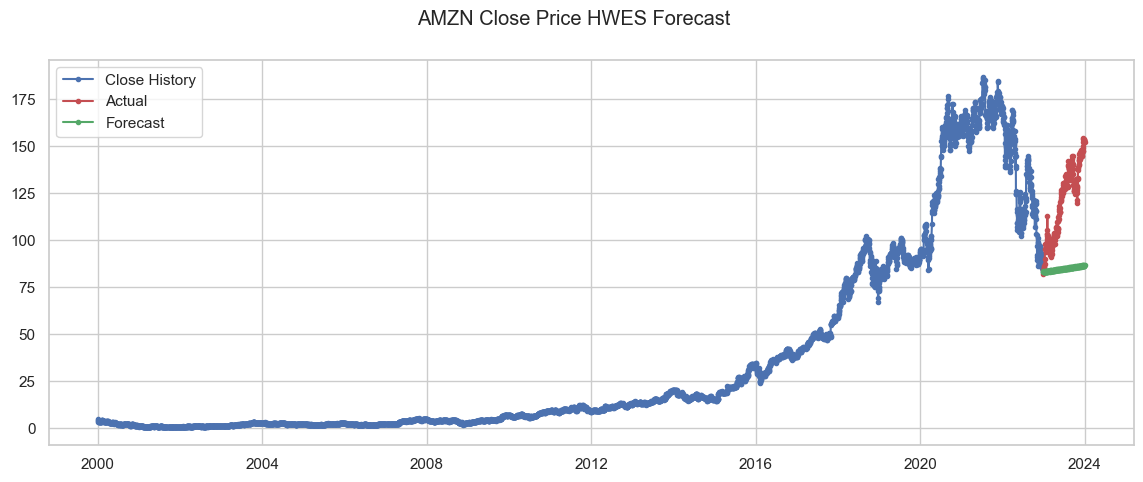

In [71]:
HWES_forecast = HWES_model_fitted.forecast(steps=253)

fig = plt.figure(figsize=(14,5))
fig.suptitle(ticker + ' Close Price HWES Forecast')
past, = plt.plot(train_df.index, train_df['Close'], 'b.-', label='Close History')
future, = plt.plot(test_df.index, test_df['Close'], 'r.-', label='Actual')
predicted_future, = plt.plot(test_df.index, HWES_forecast, 'g.-', label='Forecast')
plt.legend(handles=[past, future, predicted_future])
plt.show()

### auto_arima

In [72]:
#test_df['Close'].tail()

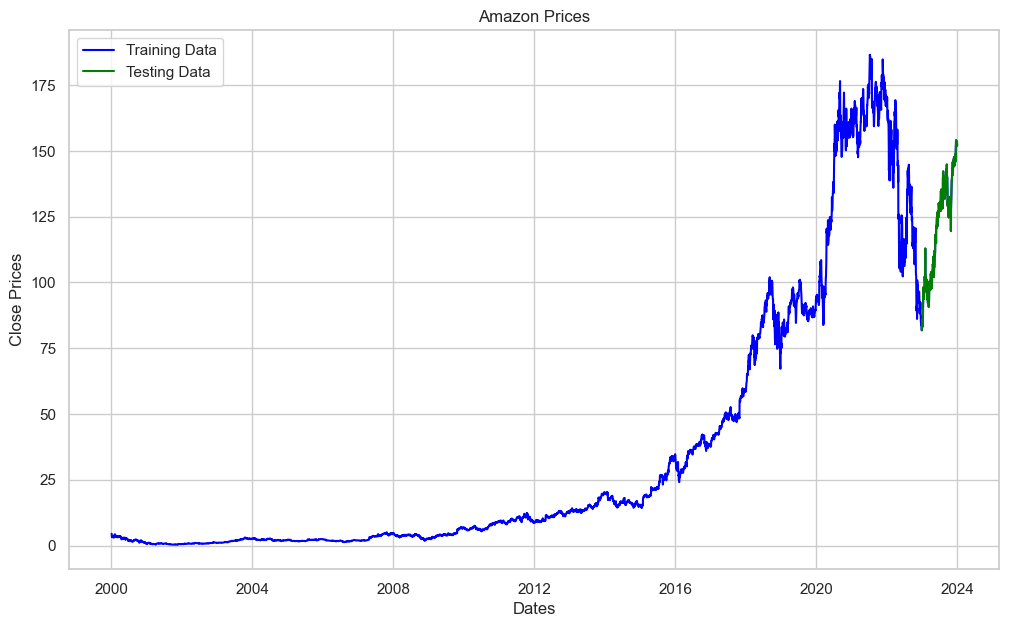

In [73]:
# Plot training and test data
plt.figure(figsize=(12,7))
plt.title('Amazon Prices')
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(stock2['Close'], 'blue', label='Training Data')
plt.plot(test_df['Close'], 'green', label='Testing Data')
plt.legend()

#### Estimating the differencing term
#### from https://alkaline-ml.com/pmdarima/usecases/stocks.html

In [74]:
from pmdarima.arima import ndiffs

kpss_diffs = ndiffs(train_df['Close'], alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train_df['Close'], alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term (d): {n_diffs}")


Estimated differencing term (d): 1


In [75]:
start = timer()
# For SARIMA Orders we set seasonal=True and pass in an m value

model_autoarima = pm.auto_arima(train_df['Close'], 
                                seasonal=True,
                                m=7, # Daily  https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period    
                                d=n_diffs,
                                max_p=3,
                                max_q=3,
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True
                               )
end = timer()
print(timedelta(seconds=end-start))

0:03:35.138217


Stepwise and exhaustive are both fine. 
Exhaustive may provide a more accurate result but will take longer, be more system intensive, and may overfit the data. 

In [76]:
results = model_autoarima.fit(train_df['Close'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 5784
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 7)   Log Likelihood               -9677.289
Date:                             Wed, 28 Feb 2024   AIC                          19370.577
Time:                                     10:01:02   BIC                          19423.878
Sample:                                          0   HQIC                         19389.121
                                            - 5784                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6961      0.003   -493.036      0.000      -1.703      -1.689
ar.L2         -0.9604      0.003   -286.365      0.000      -0.967      -0.954
ma.L1          1.6968      0.003    657.214      0.000       1.692       1.702
ma.L2          0.9774      0.003    382.814      0.000       0.972       0.982
ar.S.L7        0.5552      0.106      5.243      0.000       0.348       0.763
ar.S.L14      -0.0316      0.006     -5.217      0.000      -0.044      -0.020
ma.S.L7       -0.5522      0.106     -5.199      0.000      -0.760      -0.344
sigma2         1.6638      0.008    214.564      0.000       1.649       1.679
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):            304604.59
Prob(Q):                              0.57   Prob(JB):                         0.00
Heteroskedasticity (H):             853.32   Skew:                            -0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [77]:
print(model_autoarima.order)

(2, 1, 2)


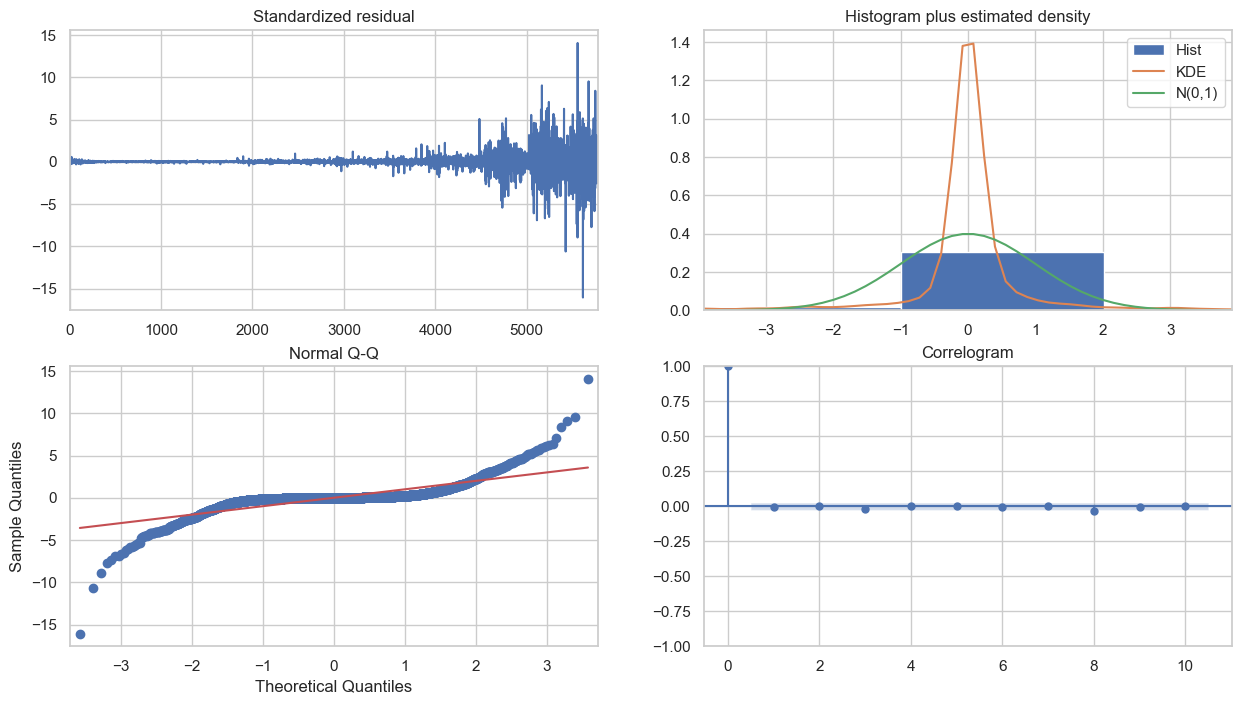

In [78]:
model_autoarima.plot_diagnostics(figsize=(15,8))
plt.show()

#### Standardized residual

    There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.
    
#### Histogram plus KDE estimate

    The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot), but not sharp
    
#### Normal Q-Q

    Most of the data points should lie on the straight line
    
#### Correlogram (ACF plot)

    95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are a few values outside of this area, and therefore we may need to add more predictors to make the model more accurate

In [79]:
# https://www.kaggle.com/code/vafaknm/stock-prices-prediction-using-classic-auto-arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from pmdarima.metrics import smape

def plot_result(model, data, col_name, Ntest):
    
    params = model.get_params()
    d = params['order'][1]
    
    #In sample data prediction
    train_pred = model.predict_in_sample(start=d, end=-1)
    #out of sample prediction
    test_pred, conf = model.predict(n_periods=Ntest, return_conf_int=True)
    
    #plotting real values, fitted values and prediction values
    fig, ax= plt.subplots(figsize=(15,8))
    #ax.plot(data[col_name].index, data[col_name], color='blue', label='Actual Values')
    #ax.plot(train_df.index[d:], train_pred, color='blue', label='Training Data')
    ax.plot(train_df.index, train_df[col_name], 'b.-', label='Close History')
    ax.plot(test_df.index, test_df[col_name], 'r.-', label='Actual')
    ax.plot(test_df.index, test_pred, color='green', label='Forecast Values')
    ax.fill_between(test_df.index, conf[:,0], conf[:,1], color='red', alpha=0.3)
    ax.legend()
    ax.set_xlabel('Dates')
    ax.set_ylabel('Close Prices')
    
    #evaluating the model using RMSE and MAE metrics
    y_true = test_df[col_name].values
    rmse = np.sqrt(mean_squared_error(y_true,test_pred))
    mae = mean_absolute_error(y_true,test_pred)
    sMAPE = smape(y_true, test_pred)
    
    return rmse, mae, sMAPE

Root Mean Squared Error:  41.90606735546411
Mean Absolute Error:  37.29221133584954
Symmetric mean absolute percentage error:  34.974943781370264


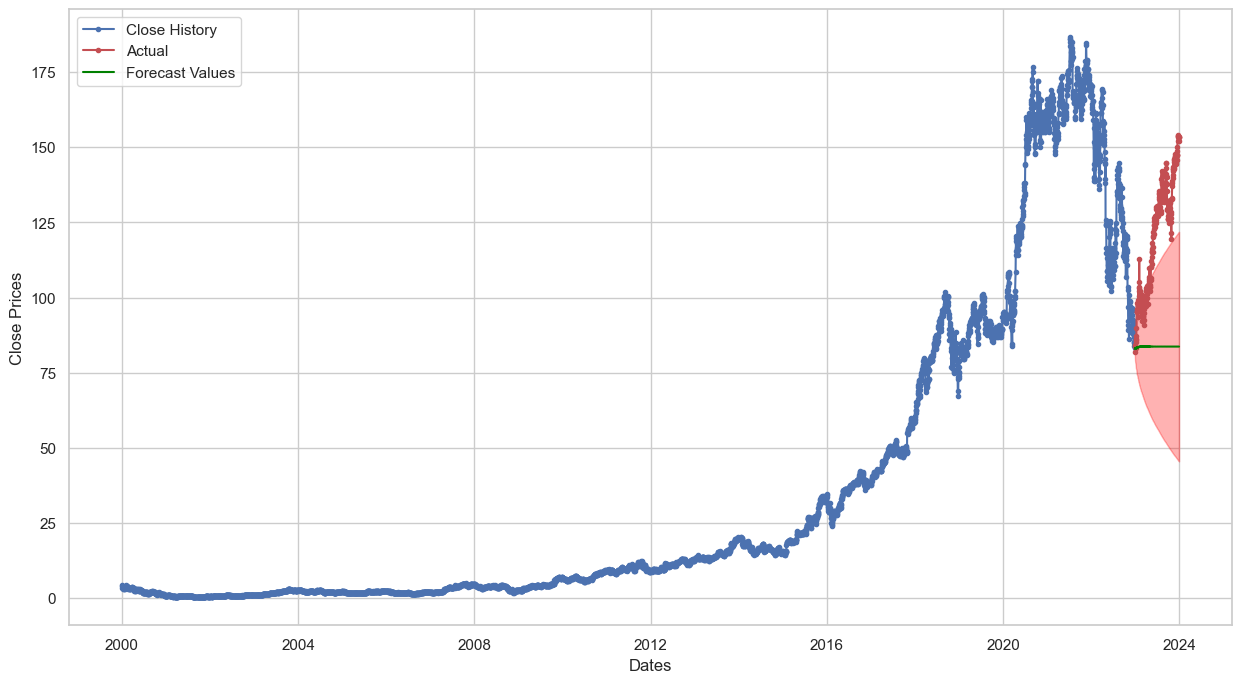

In [80]:

rmse , mae, sMAPE = plot_result(model_autoarima, stock2, 'Close', Ntest)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Symmetric mean absolute percentage error: ', sMAPE)  # an accuracy measure based on percentage (or relative) errors.

#### Grid search

In [81]:
# Seasonal - fit stepwise auto-ARIMA
start = timer()
model_SARIMA= pm.auto_arima(train_df['Close'], start_p=1, start_q=1,
                         test='adf',  # use adftest to find optimal 'd'
                         max_p=3, max_q=3, 
                         m=7, # the frequncy of the cycle
                         d=n_diffs,
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         D=1, # order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
end = timer()
print(timedelta(seconds=end-start))

0:00:19.220040


In [82]:
results2 = model_SARIMA.fit(train_df['Close'])
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5784
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -10559.588
Date:                           Wed, 28 Feb 2024   AIC                          21125.176
Time:                                   10:01:23   BIC                          21145.160
Sample:                                        0   HQIC                         21132.129
                                          - 5784                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6503      0.004   -151.995      0.000      -0.659      -0.642
ar.S.L14      -0.3203      0.004    -74.878      0.000      -0.329      -0.312
sigma2         2.2657      0.012    193.473      0.000       2.243       2.289
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            141104.56
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             893.88   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

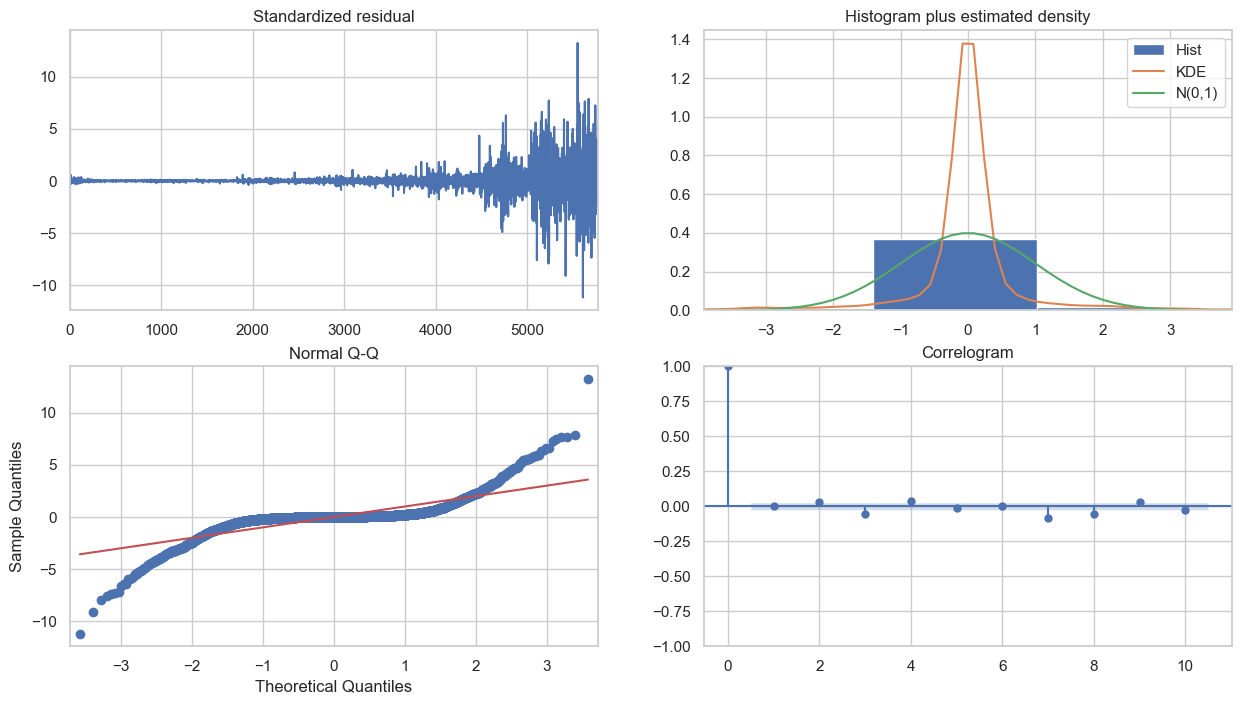

In [83]:
model_SARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Root Mean Squared Error:  114.53921850952621
Mean Absolute Error:  100.424700405486
Symmetric mean absolute percentage error:  129.7270407098514


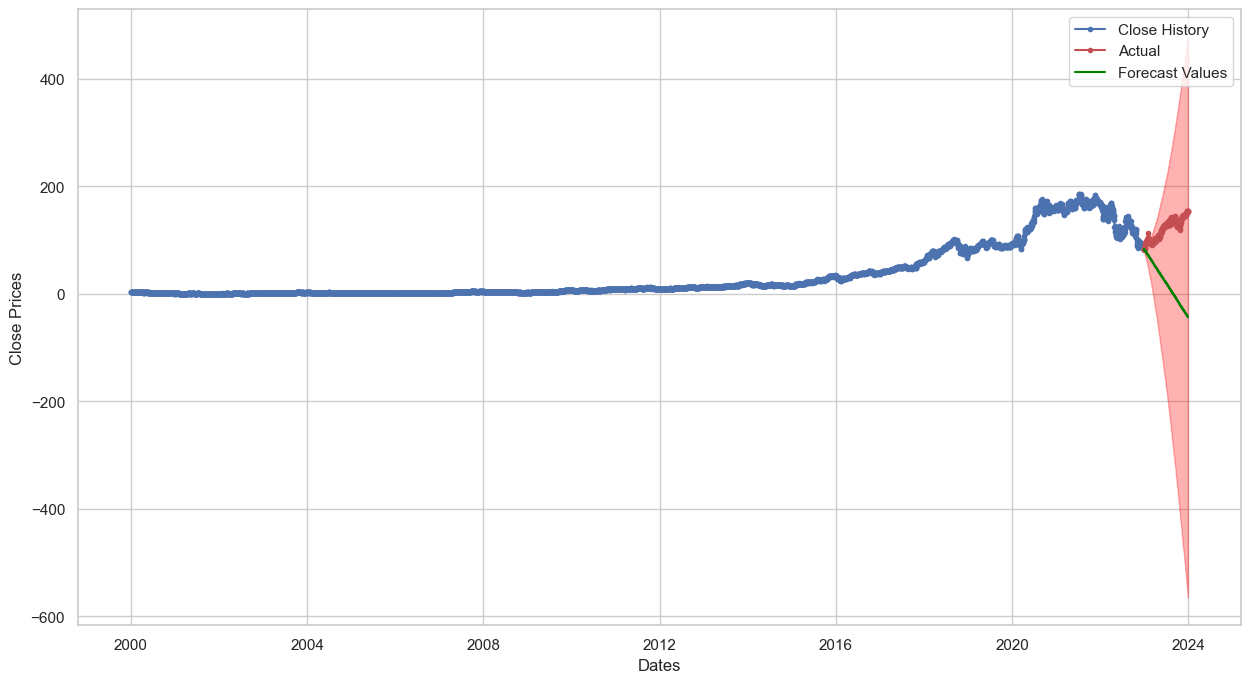

In [84]:
rmse , mae, sMAPE = plot_result(model_SARIMA, stock2, 'Close', Ntest)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Symmetric mean absolute percentage error: ', sMAPE) 

In [85]:
#adding exogenous variable

# SARIMAX Model
SARIMAX_model = pm.auto_arima(train_df['Close'], exogenous=train_df.index,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, 
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

In [86]:
results3 = SARIMAX_model.fit(train_df['Close'])
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 5784
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 7)   Log Likelihood              -10559.588
Date:                           Wed, 28 Feb 2024   AIC                          21125.176
Time:                                   10:01:44   BIC                          21145.160
Sample:                                        0   HQIC                         21132.129
                                          - 5784                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7       -0.6503      0.004   -151.995      0.000      -0.659      -0.642
ar.S.L14      -0.3203      0.004    -74.878      0.000      -0.329      -0.312
sigma2         2.2657      0.012    193.473      0.000       2.243       2.289
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            141104.56
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):             893.88   Skew:                             0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

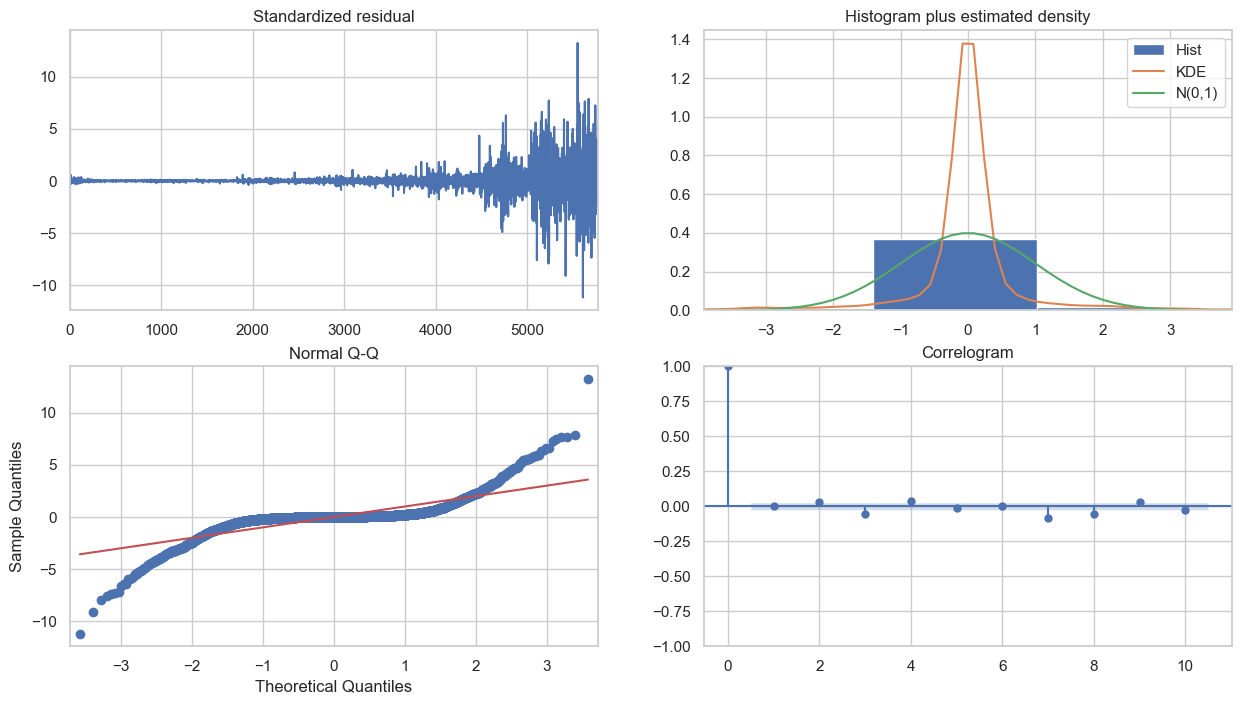

In [87]:
SARIMAX_model.plot_diagnostics(figsize=(15,8))
plt.show()

Root Mean Squared Error:  114.53921850952621
Mean Absolute Error:  100.424700405486
Symmetric mean absolute percentage error:  129.7270407098514


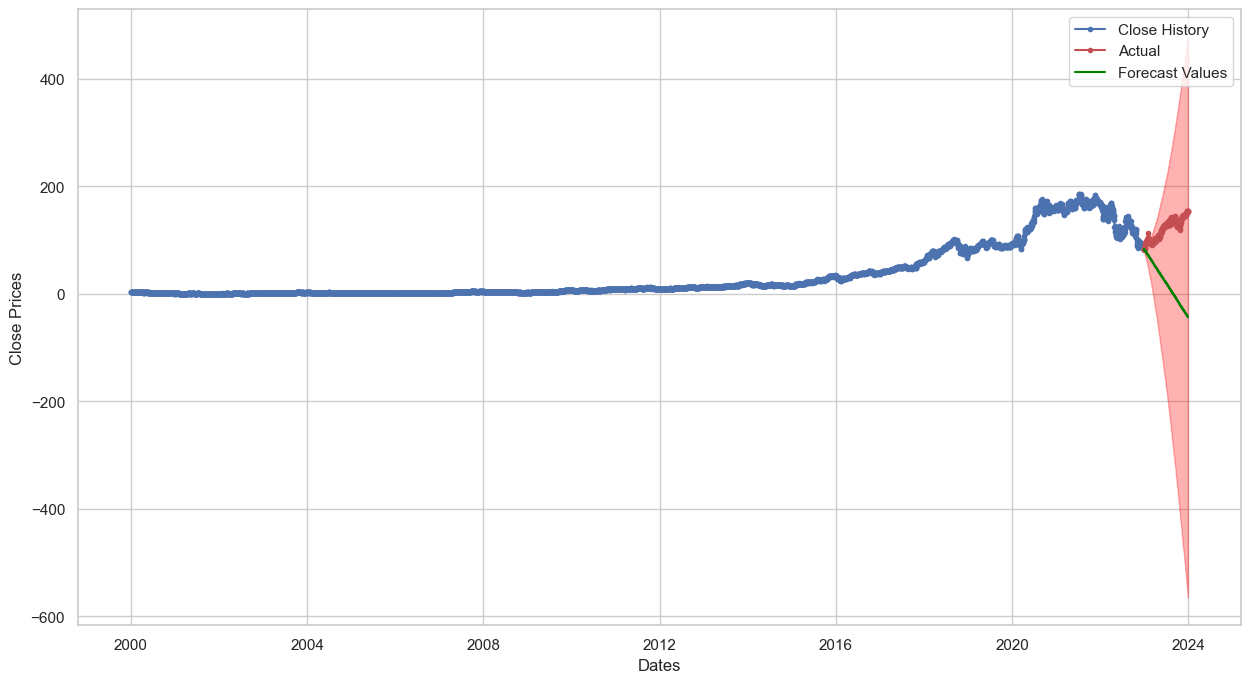

In [88]:
rmse , mae, sMAPE = plot_result(SARIMAX_model, stock2, 'Close', Ntest)
print('Root Mean Squared Error: ', rmse)
print('Mean Absolute Error: ', mae)
print('Symmetric mean absolute percentage error: ', sMAPE) 

### SARIMAX

#### https://jadsmkbdatalab.nl/forecasting-with-sarimax-models/

### Box-Jenkins Method

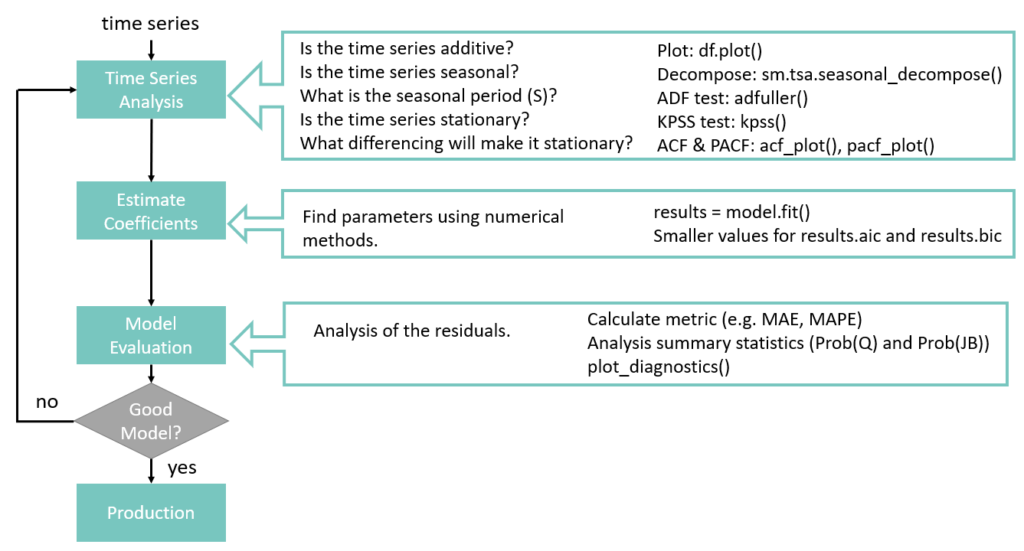

In [89]:
# from http://anthony-skolozdrzyk-ardouin.com/a-simple-grid-search-to-find-pdqpdqs-in-sarimax-forecasting-algorithm/

def sarima_grid_search(y, seasonal_period):
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                # https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax
                 # increasing the maximum number of iterations
                
                results = mod.fit(maxiter=10000)
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [90]:
start = timer()

sarima_grid_search(train_df['Close'], 7)

end = timer()
print("Time used: ",timedelta(seconds=end-start))

The set of parameters with the minimum AIC is: SARIMA(2, 1, 2)x(0, 0, 2, 7) - AIC:19338.328644541572
Time used:  1:46:41.222468


In [91]:
model_SARIMAX = sm.tsa.statespace.SARIMAX(train_df['Close'],
                                                order=(2, 1, 2),
                                                seasonal_order=(0, 0, 2, 7),
                                                enforce_stationarity=True, 
                                                enforce_invertibility=True)


# https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax
 # increasing the maximum number of iterations

results4 = model_SARIMAX.fit(maxiter=200)

In [92]:
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 5784
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -9679.699
Date:                           Wed, 28 Feb 2024   AIC                          19373.398
Time:                                   11:48:32   BIC                          19420.037
Sample:                                        0   HQIC                         19389.625
                                          - 5784                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.6969      0.003   -493.650      0.000      -1.704      -1.690
ar.L2         -0.9624      0.003   -286.247      0.000      -0.969      -0.956
ma.L1          1.6978      0.003    654.739      0.000       1.693       1.703
ma.L2          0.9783      0.003    383.269      0.000       0.973       0.983
ma.S.L7        0.0020      0.006      0.343      0.732      -0.009       0.013
ma.S.L14      -0.0183      0.006     -3.166      0.002      -0.030      -0.007
sigma2         1.6647      0.008    215.212      0.000       1.650       1.680
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):            303086.96
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):             855.51   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        38.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

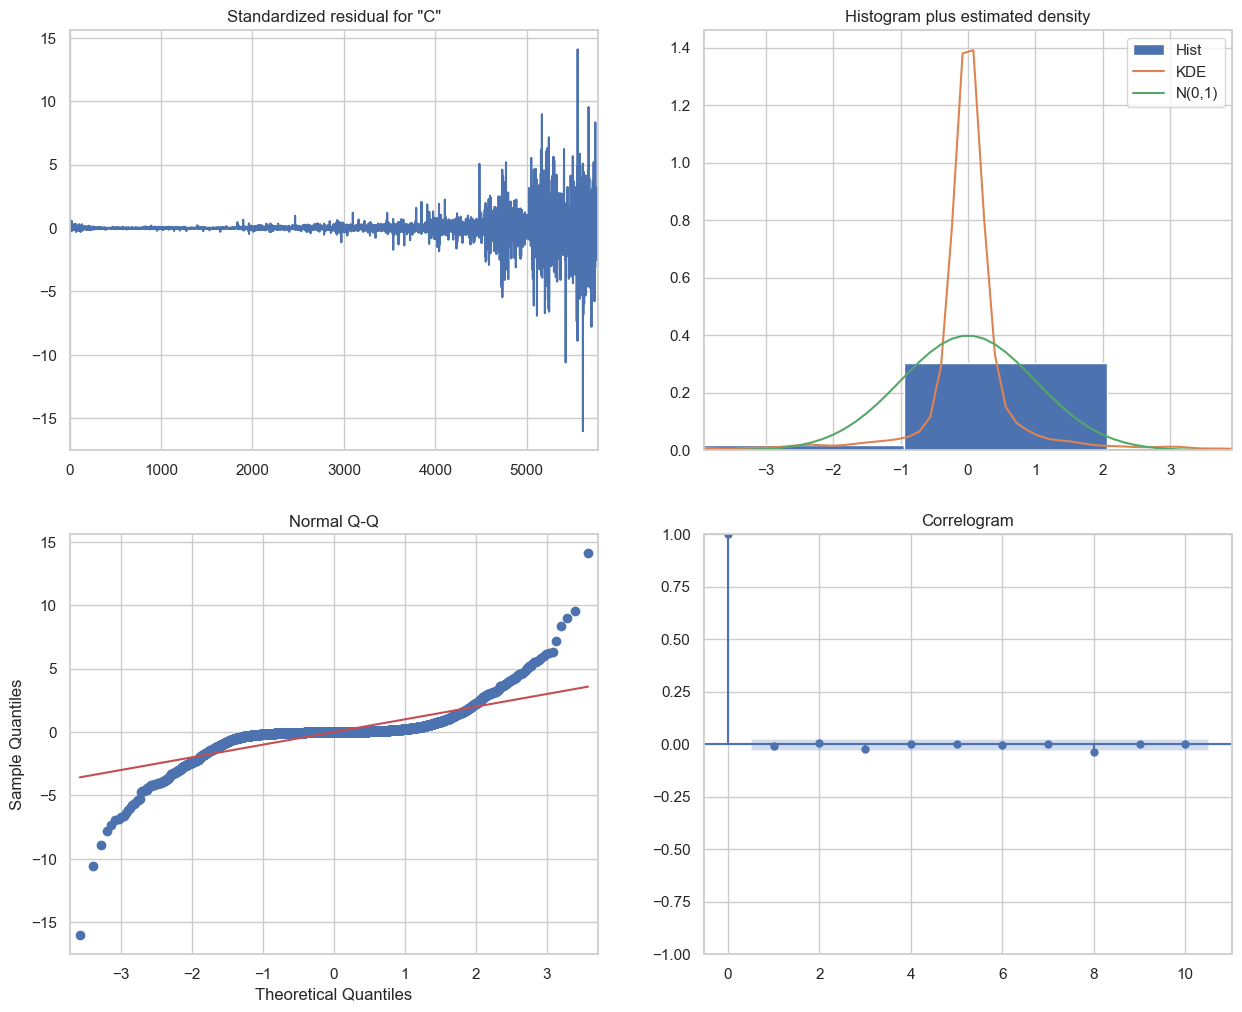

In [93]:
results4.plot_diagnostics(figsize=(15,12))
plt.show()

In [103]:
# code from https://www.kaggle.com/code/nholloway/seasonality-and-sarimax

def rolling_forecast(train, test, order, season):
    history = [x for x in train]
    model = sm.tsa.statespace.SARIMAX(history, order= order, seasonal_order= season)
    model_fit = model.fit(disp=False)
    predictions = []
    results = {}
    yhat = model_fit.forecast()[0]

    predictions.append(yhat)
    history.append(test[0])
    for i in range(1, len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order= order, seasonal_order= season)
        model_fit = model.fit(disp=False)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        obs = test[i]
        history.append(obs)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)
    rmse = np.sqrt(mse)
    predictions = pd.Series(predictions, index=test.index)
    results['predictions'] = predictions
    results['mse'] = mse
    results['rmse'] = rmse
    results['mae'] = mae
    return results

In [104]:
start = timer()

rolling_fcast = rolling_forecast(train_df['Close'], test_df['Close'], (2, 1, 2), (0, 0, 2, 7))

end = timer()
print("Time used: ",timedelta(seconds=end-start))

Time used:  0:22:56.071086


Mean Squared Error: 6.01789469153155
Root Mean Squared Error: 2.4531397619237985
Mean Absolute Error: 1.848393665838623


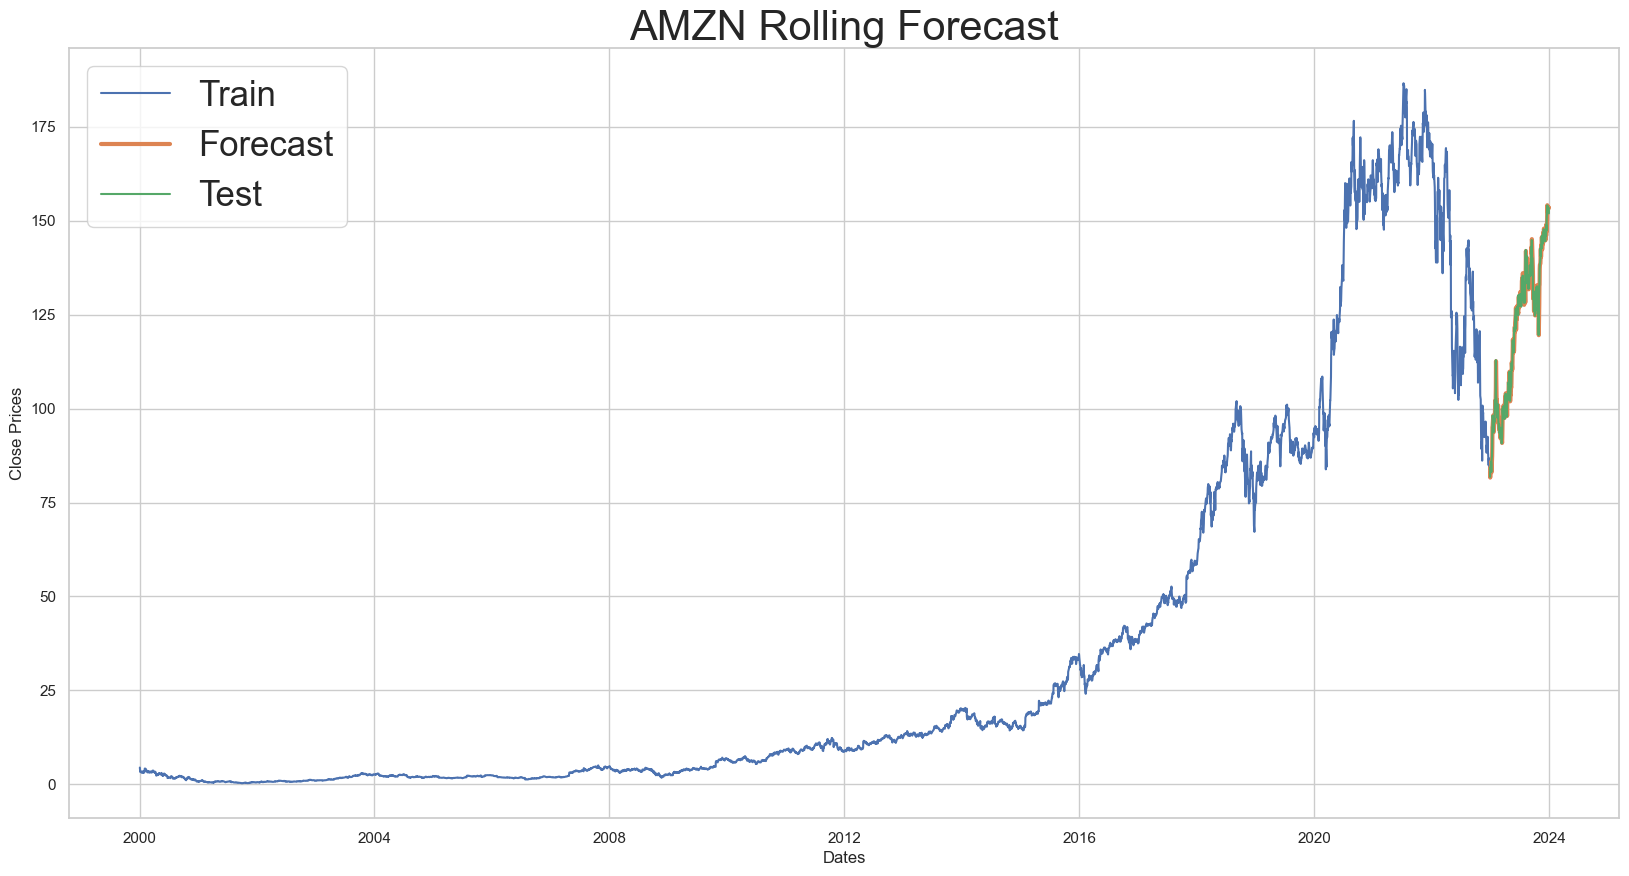

In [107]:
plt.figure(figsize=(20, 10))
plt.title(ticker + ' Rolling Forecast', fontsize=30)
plt.plot(train_df['Close'], label='Train')
plt.plot(rolling_fcast['predictions'], label='Forecast', linewidth=3)
plt.plot(test_df['Close'], label='Test')

print(f'Mean Squared Error: {rolling_fcast["mse"]}')
print(f'Root Mean Squared Error: {rolling_fcast["rmse"]}')
print(f'Mean Absolute Error: {rolling_fcast["mae"]}')
plt.legend(fontsize=25)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.show()

### The best model is SARIMAX(2, 1, 2)x(0, 0, 2, 7) for forecasting AMAZON Closing price. It's AIC value is lowest as 19373.398, and RMSE = 2.453

### Reference

####  time-series-decomposition:  
    https://github.com/amitrani6/time-series-examples/blob/master/time_series_removing_trends_and_decomposition.ipynb
    https://timeseriesreasoning.com/contents/time-series-decomposition/
    https://coderzcolumn.com/tutorials/data-science/how-to-remove-trend-and-seasonality-from-time-series-data-using-python-pandas
    https://subashpalvel.medium.com/time-series-forecasting-with-seasonal-decomposition-b86897a4b68b#:~:text=Seasonal%20decomposition%20is%20a%20technique,within%20a%20specific%20time%20period
    https://medium.datadriveninvestor.com/seasonal-trend-decomposition-759ab01b8fab
    https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
    https://github.com/amitrani6/time-series-examples/blob/master/Time_Series_Models_Examples.ipynb
    
#### acf-and-pacf:
    https://www.baeldung.com/cs/acf-pacf-plots-arma-modeling
    https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf
    https://spureconomics.com/interpreting-acf-and-pacf-plots/
     
#### time-series / arima model:
    https://medium.com/analytics-vidhya/time-series-forecasting-sarima-vs-auto-arima-models-f95e76d71d8f
    https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6
    https://towardsdatascience.com/achieving-stationarity-with-time-series-data-abd59fd8d5a0
    https://www.rasgoml.com/feature-engineering-tutorials/scikit-learn-time-series-split
    https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one
    https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two
    https://github.com/Bounteous-Inc/Time-Series-Prediction/blob/master/Time%20Series%20Prediction%20Temp.ipynb
    https://goodboychan.github.io/python/datacamp/time_series_analysis/2020/06/15/02-Fitting-the-Future.html
    https://medium.com/@shawanugya12/implementation-of-time-series-forecasting-methods-sarima-sarimax-and-prophet-ff8407b25aaa
    https://github.com/shaw-anugya/Time-Series/blob/master/SARIMAX_Implementation.ipynb

#### stock prediction:
    https://towardsdatascience.com/forecasting-time-series-data-stock-price-analysis-324bcc520af5
    https://github.com/thakarprathamesh/Time-Series-Analysis/blob/master/Stock_Market_Analysis.ipynb
    https://github.com/nayash/Stock-Price-Prediction/blob/master/stock_pred_main.py
    https://github.com/huseinzol05/Stock-Prediction-Models/blob/master/deep-learning/how-to-forecast.ipynb
    https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
    https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944    
    https://jovian.com/bhatnagar91/time-series-forecasting-using-univariate-arima
    https://alkaline-ml.com/pmdarima/usecases/stocks.html
    https://github.com/pierpaolo28/Kaggle-Challenges/blob/master/stock-market-analysis-and-time-series-prediction.ipynb
    https://www.kaggle.com/code/vafaknm/stock-prices-prediction-using-classic-auto-arima
    https://nzlul.medium.com/stock-price-prediction-using-auto-arima-5569fcceae59